In [1]:
import tensorflow as tf
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import tensorflow_probability as tfp
from sklearn.base import  BaseEstimator, TransformerMixin
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from google.colab import drive
import pdb
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive




# Multiple Annotators Models

In [3]:
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 6.1 MB/s eta 0:00:00


In [4]:
# -*- coding: utf-8 -*-
"""Keras_CKA.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1IjISolh0J4scGwmy0l8sWIQAaqZkc-eR
"""
import tensorflow as tf
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import tensorflow_probability as tfp
from sklearn.base import  BaseEstimator, TransformerMixin
import numpy as np
from umap import UMAP

class CKA(BaseEstimator, TransformerMixin):
    """Class for computing the Centered Kernel Alignment (CKA).

    This class provides methods to compute the CKA loss, fit the model,
    transform the data, and plot the history and kernels.

    Parameters:
    -----------
    epochs: int, default=50
        Number of epochs for training.
    batch_size: int, default=100
        Batch size for training.
    ls_X: float, default=1e-2
        Length scale for the input features kernel.
    ls_Y: float, default=1e-13
        Length scale for the label kernel.
    iAnn: array-like of shape (n_samples, n_annotators), default=ones(2)
        Annotation matrix.
    lr: float, default=1e-2
        Learning rate for optimization.
    l1: float, default=1e-3
        L1 regularization parameter.
    l2: float, default=1e-3
        L2 regularization parameter.

    Methods:
    --------
    __init__(self, epochs=50, batch_size=100, ls_X=1e-2, ls_Y=1e-13, iAnn=np.ones(2), lr=1e-2, l1=1e-3, l2=1e-3)
    Constructor method for the CKA class.

    fit(self, X, Y)
    Fits the model using the provided data.


    transform(self, X, *_)
    Transforms the data using the trained model.


    fit_transform(self, X, y)
    Fits the model to the data and transforms it.


    plot_history(self)
    Plots the training loss history.

    plot_kernels(self, X, Y, iAnn)
    Plots the kernels computed during training.


    ComputeKernel_X(self, X)
    Computes the exponential quadratic kernel over the input features.


    ComputeKernel_Y(self, Y, iAnn)
    Computes the linear kernel over the labels.


    CKA_loss(self, X, Y, iAnn)
    Defines the loss function based on the centered kernel alignment framework.


    """
    def __init__(self,epochs=50,batch_size=100,ls_X=1e-2,
                 ls_Y=1e-13,iAnn=2,lr=1e-2,l1=1e-3,l2=1e-3):
        self.epochs = epochs
        self.batch_size = batch_size
        if isinstance(iAnn, int):
            iAnn = np.ones((iAnn, iAnn))
        self.iAnn = iAnn
        self.R = self.iAnn.shape[1] #annotators
        self.mu = tf.Variable(tf.random.uniform(shape=(1, self.R), dtype=tf.float64))
        self.ls_X = tf.Variable(ls_X, dtype=tf.float64)
        self.ls_Y = tf.Variable(ls_Y, dtype=tf.float64)
        self.lr = lr
        self.l1 = l1
        self.l2 = l2

    # function to compute an exponetial quadratic kernel over the input features
    def ComputeKernel_X(self,X):
        """
        Parameters:
        -----------
        X: array-like of shape (n_samples, n_features)
            Input features.

        Returns:
        --------
        Kernel matrix.
        """
        kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(length_scale=self.ls_X,
                                                  name='ExponentiatedQuadratic')
        return kernel.matrix(X,X)

    # function to compute a linear kernel over the labels.
    def ComputeKernel_Y(self,Y,iAnn):
        """
        Parameters:
        -----------
        Y: array-like of shape (n_samples, n_annotators)
            Labels.
        iAnn: array-like of shape (n_samples, n_annotators)
            Annotation matrix.

        Returns:
        --------
        Kernel matrix.
        """
        #kernel = tfp.math.psd_kernels.Linear(bias_amplitude=None,
        #                                     slope_amplitude=None, shift=None,
        #                                     feature_ndims=1,validate_args=False,
        #                                     name='Linear')
        self.kernelY = tfp.math.psd_kernels.ExponentiatedQuadratic(length_scale=self.ls_Y,
                                                  name='ExponentiatedQuadratic')
        # pdb.set_trace()
        N, R = Y.shape
        Y = tf.multiply(Y,iAnn)
        K_mu = tf.zeros([N,N], dtype=tf.dtypes.float64)
        for r in range(R):
            iann = tf.tensordot(iAnn[:,r], iAnn[:,r], 0)
            # ker = tf.linalg.set_diag(tf.multiply(self.kernelY.matrix(Y[:,r:r+1],Y[:,r:r+1]), iann), tf.ones_like(iAnn[:,r]))
            ker = tf.multiply(self.kernelY.matrix(Y[:,r:r+1],Y[:,r:r+1]), iann)
            # K_mu = tf.math.add(K_mu,self.mu[0,r]*self.kernelY.matrix(Y[:,r:r+1],Y[:,r:r+1]))
            K_mu = tf.math.add(K_mu,self.mu[0,r]*ker)
        return K_mu

    # we define the loss fuction based on the centered kernel alignment framework
    def CKA_loss(self,X,Y,iAnn):
        """
        Parameters:
        -----------
        X: array-like of shape (n_samples, n_features)
            Input features.
        Y: array-like of shape (n_samples, n_annotators)
            Labels.
        iAnn: array-like of shape (n_samples, n_annotators)
            Annotation matrix.

        Returns:
        --------
        CKA loss.
        """
        N = X.shape[0]
        KXX = self.ComputeKernel_X(X)
        Kmu = self.ComputeKernel_Y(Y,iAnn)
        I = tf.eye(N, dtype=tf.dtypes.float64)
        ones = tf.ones([N,1], dtype=tf.dtypes.float64)
        H = I - tf.linalg.matmul(ones, ones, transpose_b=True)/N
        KXX_c = tf.linalg.matmul(H,tf.linalg.matmul(KXX,H))
        Kmu_c = tf.linalg.matmul(H,tf.linalg.matmul(Kmu,H))
        num = tf.linalg.trace(tf.matmul(Kmu_c,KXX_c,transpose_a=True))
        den1 = tf.sqrt(tf.linalg.trace(tf.matmul(Kmu_c,Kmu_c,transpose_a=True)))
        den2 = tf.sqrt(tf.linalg.trace(tf.matmul(KXX_c,KXX_c,transpose_a=True)))


        return -num/(den1*den2) + self.l2*tf.norm(self.mu,ord=2)+self.l1*tf.norm(self.mu,ord=1)

    def fit(self,X,Y):
        """
        Parameters:
        -----------
        X: array-like of shape (n_samples, n_features)
            Input features.
        Y: array-like of shape (n_samples, n_annotators)
            Labels.

        Returns:
        --------
        None
        """
        batch_size = self.batch_size
        train_data=tf.data.Dataset.from_tensor_slices((X,Y,self.iAnn))
        train_data=train_data.shuffle(buffer_size=100).batch(batch_size).repeat(5)
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=self.lr,
                                decay_steps=10,decay_rate=0.9)
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
        self.loss_ = np.zeros(self.epochs)
        for epoch in range(self.epochs):
            # if epoch % 10 == 0:
            #     print("Start of epoch %d" % (epoch,))
            print("Start of epoch %d" % (epoch,))
            # Iterate over the batches of the dataset.
            for step, (x_batch_train,y_batch_train,iAnn_batch) in enumerate(train_data):
                with tf.GradientTape() as tape:
                    loss =  self.CKA_loss(x_batch_train, y_batch_train,iAnn_batch)
                grads = tape.gradient(loss, [self.mu])
                self.optimizer.apply_gradients(zip(grads, [self.mu]))
                #grads = tape.gradient(loss, [self.mu, self.ls_X])
                #self.optimizer.apply_gradients(zip(grads, [self.mu, self.ls_X]))


                if step % 50 == 0:
                    mu_ = self.mu.numpy()[0]
                    mu_[mu_<0] = 0
                    mu_ = mu_/np.sum(mu_)
                    print(f"step {step}: mean loss {loss.numpy().round(4)} ls {self.ls_X.numpy().round(2)} lr {(self.optimizer.learning_rate.numpy()).round(5)} mu {mu_.round(2)}" )
            self.loss_[epoch] = loss
        return

    def transform(self, X, *_):
        """
                Parameters:
        -----------
        X: array-like of shape (n_samples, n_features)
            Input features.

        Returns:
        --------
        Transformed data.
        """
        mu = self.mu.numpy()[0]
        mu[mu<0] = 0
        mu = mu/np.sum(mu)

        return mu

    def fit_transform(self,X,y):
        """
        Parameters:
        -----------
        X: array-like of shape (n_samples, n_features)
            Input features.
        Y: array-like of shape (n_samples, n_annotators)
            Labels.

        Returns:
        --------
        Transformed data.
        """
        self.fit(X,y)
        return  self.transform(X)

    def plot_history(self):
        fig,ax = plt.subplots(1,figsize=(3,3))
        ax.plot(np.arange(self.epochs),self.loss_)
        ax.set_xlabel('epochs')
        ax.set_ylabel('loss')
        plt.show()
        return

    def plot_kernels(self,X,Y,iAnn,annotators=None):
        """
        Parameters:
        -----------
        X: array-like of shape (n_samples, n_features)
            Input features.
        Y: array-like of shape (n_samples, n_annotators)
            Labels.
        iAnn: array-like of shape (n_samples, n_annotators)
            Annotation matrix.

        Returns:
        --------
        None
        """

        N, R = Y.shape
        fig,ax = plt.subplots(nrows = 1,ncols=R+2,figsize=(4*(R+2),3))
        #K features
        KXX = self.ComputeKernel_X(X)
        ax[0].imshow(KXX,vmin=0,vmax=1)
        ax[0].set_title(f"Target")
        ax[0].set_xticks([])
        ax[0].set_yticks([])

        #K Y annotators and Kmu
        Y = tf.multiply(Y,iAnn)
        K_mu = tf.zeros([N,N], dtype=tf.dtypes.float64)
        mu_ = self.mu.numpy()[0]
        mu_[mu_<0] = 0
        mu_ = mu_/np.sum(mu_)
        for r in range(R):
            K_mu = tf.math.add(K_mu,mu_[r]*self.kernelY.matrix(Y[:,r:r+1],Y[:,r:r+1]))

        ax[1].imshow(K_mu,vmin=0,vmax=1)
        ax[1].set_title(f"$K_\mu$")
        ax[1].set_xticks([])
        ax[1].set_yticks([])

        if annotators is None:
            for r in range(R):
                ax[r+2].imshow(mu_[r]*self.kernelY.matrix(Y[:,r:r+1],Y[:,r:r+1]),vmin=0,vmax=1)
                ax[r+2].set_title(f"A{r+1} - $K\mu_{{r+1}}={mu_[r].round(2)}$")
                ax[r+2].set_xticks([])
                ax[r+2].set_yticks([])
        else:
            for r, ann in enumerate(annotators):
                ax[r+2].imshow(mu_[r]*self.kernelY.matrix(Y[:,r:r+1],Y[:,r:r+1]),vmin=0,vmax=1)
                ax[r+2].set_title(f"A{ann} - $K\mu_{{{ann}}}={mu_[r].round(2)}$")
                ax[r+2].set_xticks([])
                ax[r+2].set_yticks([])
        cax = fig.add_axes([0.925, 0.15, 0.01, 0.7])
        norm = matplotlib.colors.Normalize(vmin=0,vmax=1)
        sm = plt.cm.ScalarMappable(cmap=None, norm=norm)
        sm.set_array([])
        cbar = plt.colorbar(sm,cax=cax)
        plt.show()

        return


In [5]:
# -*- coding: utf-8 -*-
"""KLCKA_CKA.ipynb

Julian Gil Gonzalez
Universidad Tecnologica de Pereira, 2021
"""
import tensorflow as tf
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import tensorflow_probability as tfp
from sklearn.base import  BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import pandas as pd
from scipy.special import softmax
from scipy.spatial.distance import cdist

class LCKA(BaseEstimator, TransformerMixin):
    """Class for computing the LCKA (Linear Centered Kernel Alignment).

    This class provides methods to compute the LCKA loss, fit the model,
    transform the data, and plot the history and kernels.

    Parameters:
    -----------
    epochs: int, default=50
        Number of epochs for training.
    batch_size: int, default=100
        Batch size for training.
    ls_X: float, default=1e-1
        Length scale for the input features kernel.
    ls_Y: float, default=1e-13
        Length scale for the label kernel.
    iAnn: array-like of shape (n_samples, n_annotators), default=ones(2)
        Annotation matrix.
    l1: float, default=1e-3
        L1 regularization parameter.
    l2: float, default=1e-3
        L2 regularization parameter.
    lr: float, default=1e-3
        Learning rate for optimization.

    Methods:
    --------
    __init__(self, epochs=50, batch_size=100, ls_X=1e-1, ls_Y=1e-13, iAnn=np.ones(2), l1=1e-3, l2=1e-3, lr=1e-3)
    Constructor method for the LCKA class.

    ComputeKernel_X(self, X)
    Compute an exponetial quadratic kernel over the input features


    ComputeKernel_Y(self, Y, iAnn, KXX, idx)
    Compute a linear kernel over the labels.


    Compute_Q(self, KXX, iAnn, idx)
    Compute the Q matrix used for kernel.


    fit(self, X, Y)
    Fits the model using the provided data.


    transform(self, X, *_)
    Transforms the data using the trained model.


    fit_transform(self, X, y)
    Fits the model to the data and transforms it.


    plot_history(self)
    Plots the training loss history.


    plot_kernels(self, X, Y, iAnn)
    Plots the kernels computed during training.

    LCKA_loss(self,X,Y,iAnn,idx)
    LCKA_loss calculates the loss function for the LCKA model.


    plot_lckaQ(self, X, q, redlcka='umap', random_state=123, n_neighbors=10, cmap='Reds')
    Plots the transformed data using either UMAP or t-SNE and color-coded by q values.

    """
    def __init__(self,epochs=50,batch_size=100,ls_X=1e-1,ls_Y=1e-13,iAnn=2,l1=1e-3,l2=1e-3,lr=1e-3):
        self.epochs = epochs
        self.batch_size = batch_size
        if isinstance(iAnn, int):
            iAnn = np.ones((iAnn, iAnn))
        self.iAnn = iAnn
        self.N, self.R = self.iAnn.shape #annotators
        self.beta = tf.Variable(tf.random.uniform(shape=(self.N+1, self.R),
                                                  dtype=tf.float64))
        self.ls_X = tf.Variable(ls_X, dtype=tf.float64)
        self.ls_Y = tf.Variable(ls_Y, dtype=tf.float64)
        self.idx = tf.range(1,self.N+1,dtype=tf.int64)
        self.q = np.zeros((self.N, self.R))
        self.l1 = l1
        self.l2 = l2
        self.lr = lr

    # function to compute an exponetial quadratic kernel over the input features
    def ComputeKernel_X(self,X):
        """
        Parameters:
        -----------
        X: array-like de forma (n_samples, n_features)
            Características de entrada.
        Returns:
        --------
        Matriz de kernel.
        """
        self.kernelX = tfp.math.psd_kernels.ExponentiatedQuadratic(length_scale=self.ls_X,
                                                  name='ExponentiatedQuadratic')
        return self.kernelX.matrix(X,X)

    # function to compute a linear kernel over the labels.
    def ComputeKernel_Y(self,Y,iAnn,KXX,idx):
        """
        Parameters:
        -----------
        Y: array-like de forma (n_samples, n_annotators)
            Etiquetas.
        iAnn: array-like de forma (n_samples, n_annotators)
            Matriz de anotación.
        KXX: array-like de forma (n_samples, n_samples)
            Kernel sobre las características de entrada.
        idx: array-like de forma (n_samples,)
            Índices de las muestras.
        Returns:
        --------
        Matriz de kernel.
        """
        #kernel = tfp.math.psd_kernels.Linear(bias_variance=None,
         #                                    slope_variance=None, shift=None,
         #                                    feature_ndims=1,validate_args=False,
         #                                    name='Linear')
        self.kernelY = tfp.math.psd_kernels.ExponentiatedQuadratic(length_scale=self.ls_Y,
                                                  name='ExponentiatedQuadratic')
        N, R = Y.shape
        Y = tf.multiply(Y,iAnn)
        K_mu = tf.zeros([N,N], dtype=tf.dtypes.float64)
        q = self.Compute_Q(KXX,iAnn,idx)
        N = KXX.shape[0]
        I = tf.eye(N, dtype=tf.dtypes.float64)
        ones = tf.ones([N,1], dtype=tf.dtypes.float64)
        H = I - tf.linalg.matmul(ones, ones, transpose_b=True)/N
        for r in range(R):
            Q = tf.linalg.diag(q[:,r])
            iann = tf.tensordot(iAnn[:,r], iAnn[:,r], 0)
            # KYY_c = tf.linalg.matmul(H,tf.linalg.matmul(self.kernelY.matrix(Y[:,r:r+1],Y[:,r:r+1]),H))
            KYY_c = tf.linalg.matmul(H,tf.linalg.matmul(tf.multiply(self.kernelY.matrix(Y[:,r:r+1],Y[:,r:r+1]),H), iann))
            Kq = tf.linalg.matmul(Q,tf.linalg.matmul(KYY_c,Q))
            K_mu = tf.math.add(K_mu,Kq)
        return K_mu

    def Compute_Q(self,KXX,iAnn,idx):
        """
        Parameters:
        -----------
        KXX: array-like de forma (n_samples, n_samples)
            Kernel sobre las características de entrada.
        iAnn: array-like de forma (n_samples, n_annotators)
            Matriz de anotación.
        idx: array-like de forma (n_samples,)
            Índices de las muestras.
        Returns:
        --------
        Matriz Q.
        """
        ones = tf.ones([KXX.shape[0],1], dtype=tf.dtypes.float64)
        KXX = tf.concat([ones, KXX], 1)
        beta = tf.gather(self.beta,idx)
        beta = tf.concat([self.beta[0:1,:], beta], 0)
        q = tf.multiply(tf.linalg.matmul(KXX, beta), iAnn)
        self.q[idx.numpy()-1,:] = q.numpy()
        return q


    # we define the loss fuction based on the centered kernel alignment framework
    def LCKA_loss(self,X,Y,iAnn,idx):
        """
        Parameters:
        -----------
        X: array-like, shape (n_samples, n_features)
            Input data.
        Y: array-like, shape (n_samples, n_annotators)
            Annotation data.
        iAnn: array-like, shape (n_samples, n_annotators)
            Annotation matrix.
        idx: array-like, shape (n_samples,)
            Indices.

        Returns:
        --------
        Loss value.
        """
        N = X.shape[0]
        KXX = self.ComputeKernel_X(X)
        Kmu_c = self.ComputeKernel_Y(Y,iAnn,KXX,idx)
        I = tf.eye(N, dtype=tf.dtypes.float64)
        ones = tf.ones([N,1], dtype=tf.dtypes.float64)
        H = I - tf.linalg.matmul(ones, ones, transpose_b=True)/N
        KXX_c = tf.linalg.matmul(H,tf.linalg.matmul(KXX,H))
        num = tf.linalg.trace(tf.matmul(Kmu_c,KXX_c,transpose_a=True))
        den1 = tf.sqrt(tf.linalg.trace(tf.matmul(Kmu_c,Kmu_c,transpose_a=True)))
        den2 = tf.sqrt(tf.linalg.trace(tf.matmul(KXX_c,KXX_c,transpose_a=True)))
        return -num/(den1*den2) + self.l2*tf.norm(self.beta,ord=2)+self.l1*tf.norm(self.beta,ord=1)

    def fit(self,X,Y):
        """
        Parameters:
        -----------
        X: array-like of shape (n_samples, n_features)
            Input features.
        Y: array-like of shape (n_samples, n_annotators)
            Labels.

        Returns:
        --------
        None
        """
        batch_size = self.batch_size
        train_data=tf.data.Dataset.from_tensor_slices((X,Y,self.iAnn,
                                                       self.idx))
        train_data=train_data.shuffle(buffer_size=100).batch(batch_size).repeat(5)
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=self.lr,
                                decay_steps=50,decay_rate=0.9)
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
        self.loss_ = np.zeros(self.epochs)
        for epoch in range(self.epochs):
            if epoch % 10 == 0:
                print("Start of epoch %d" % (epoch,))

            # Iterate over the batches of the dataset.
            for step, (x_batch_train,y_batch_train,iAnn_batch,
                       idx_batch) in enumerate(train_data):
                with tf.GradientTape() as tape:
                    loss = self.LCKA_loss(x_batch_train, y_batch_train,
                                         iAnn_batch,idx_batch)
                grads = tape.gradient(loss, [self.beta, self.ls_X])
                self.optimizer.apply_gradients(zip(grads, [self.beta, self.ls_X]))

                if step % 50 == 0:
                     print(f"step {step}: mean loss {loss.numpy().round(4)} ls {self.ls_X.numpy().round(2)} lr {(self.optimizer.learning_rate.numpy()).round(5)}" )
            self.loss_[epoch] = loss
    def transform(self, X, *_):
        """
        Parameters:
        -----------
        X: array-like of shape (n_samples, n_features)
            Input features.

        Returns:
        --------
        Transformed data.
        """
        q = self.q**2
        #N = q.shape[0]
        q = softmax(q,axis=1)#np.sum(q,1).reshape(N,1)

        return q

    def fit_transform(self,X,y):
        """
        Parameters:
        -----------
        X: array-like of shape (n_samples, n_features)
            Input features.
        Y: array-like of shape (n_samples, n_annotators)
            Labels.

        Returns:
        --------
        Transformed data.
        """
        self.fit(X,y)
        return  self.transform(X)


    def plot_history(self):
      fig,ax = plt.subplots(1,figsize=(3,3))
      ax.plot(np.arange(self.epochs),self.loss_)
      ax.set_xlabel('epochs')
      ax.set_ylabel('loss')
      plt.show()
      return

    def plot_kernels(self,X,Y,iAnn,annotators=None):
        """
        Parameters:
        -----------
        X: array-like of shape (n_samples, n_features)
            Input features.
        Y: array-like of shape (n_samples, n_annotators)
            Labels.
        iAnn: array-like of shape (n_samples, n_annotators)
            Annotation matrix.

        Returns:
        --------
        None
        """

        N, R = Y.shape
        idx = tf.range(1,N+1,dtype=tf.int64)
        KXX = self.ComputeKernel_X(X)
        K_mu = self.ComputeKernel_Y(Y,iAnn,KXX,idx)

        fig,ax = plt.subplots(nrows = 1,ncols=R+2,figsize=(4*(R+2),3))

        ax[0].imshow(KXX,vmin=0,vmax=1)
        ax[0].set_title(f"Target")
        ax[0].set_xticks([])
        ax[0].set_yticks([])

        ax[1].imshow(K_mu,vmin=0,vmax=1)
        ax[1].set_title(f"$K_\mu$")
        ax[1].set_xticks([])
        ax[1].set_yticks([])

        q = (self.q)**2
        q = 100*softmax(q,axis=1)
        print(q.shape)
        I = tf.eye(N, dtype=tf.dtypes.float64)
        ones = tf.ones([N,1], dtype=tf.dtypes.float64)
        H = I - tf.linalg.matmul(ones, ones, transpose_b=True)/N
        vmin_=0
        vmax_=KXX.numpy().max()
        if annotators is None:
            for r in range(R):
                Q = tf.linalg.diag(q[:,r])
                KYY_c = tf.linalg.matmul(H,tf.linalg.matmul(self.kernelY.matrix(Y[:,r:r+1],Y[:,r:r+1]),H))
                Kq = tf.linalg.matmul(Q,tf.linalg.matmul(KYY_c,Q))
                ax[r+2].imshow(Kq,vmin=0,vmax=1)
                ax[r+2].set_title(f"A{r+1}")
                ax[r+2].set_xticks([])
                ax[r+2].set_yticks([])
        else:
            for r, ann in enumerate(annotators):
                Q = tf.linalg.diag(q[:,r])
                KYY_c = tf.linalg.matmul(H,tf.linalg.matmul(self.kernelY.matrix(Y[:,r:r+1],Y[:,r:r+1]),H))
                Kq = tf.linalg.matmul(Q,tf.linalg.matmul(KYY_c,Q))
                ax[r+2].imshow(Kq,vmin=0,vmax=1)
                ax[r+2].set_title(f"A{ann}")
                ax[r+2].set_xticks([])
                ax[r+2].set_yticks([])

        cax = fig.add_axes([0.925, 0.15, 0.01, 0.7])
        norm = matplotlib.colors.Normalize(vmin=0,vmax=vmax_)
        sm = plt.cm.ScalarMappable(cmap=None, norm=norm)
        sm.set_array([])
        cbar = plt.colorbar(sm,cax=cax)
        plt.show()
        return q


    def plot_lckaQ(self,X,q, redlcka='umap',random_state=123,n_neighbors=10,cmap='Reds',annotators=None):
        """
        Parameters:
        -----------
        X: array-like of shape (n_samples, n_features)
            Input features.
        q: array-like of shape (n_samples, n_annotators)
            Transformed data.
        redlcka: {'umap', 'tsne'}, default='umap'
            Reduction method to use.
        random_state: int, default=123
            Random state for reproducibility.
        n_neighbors: int, default=10
            Number of neighbors to consider for UMAP or t-SNE.
        cmap: str, default='Reds'
            Colormap to use.

        Returns:
        --------
        None
        """
        if redlcka == 'umap':
            red_ = UMAP(n_components = 2, n_neighbors = n_neighbors,min_dist =0.9,random_state=random_state)
        else:
            red_ = TSNE(n_components = 2, perplexity = n_neighbors, random_state=random_state)
        X_ = MinMaxScaler().fit_transform(X)
        Z = red_.fit_transform(X_)
        R = q.shape[1]

        fig,ax = plt.subplots(nrows = 1,ncols=R,figsize=(4*(R),3))
        if annotators is None:
            for r in range(R):
                ax[r].scatter(Z[:,0],Z[:,1],c=q[:,r],vmin=q.ravel().min(),vmax=q.ravel().max(),cmap=cmap)
                ax[r].set_title(f"A{r+1} - qm = {q[:,r].ravel().mean().round(2)}")
                ax[r].set_xticks([])
                ax[r].set_yticks([])
        else:
            for r, ann in enumerate(annotators):
                ax[r].scatter(Z[:,0],Z[:,1],c=q[:,r],vmin=q.ravel().min(),vmax=q.ravel().max(),cmap=cmap)
                ax[r].set_title(f"A{ann} - qmean = {q[:,r].ravel().mean().round(2)}\n qmed = {np.median(q[:,r].ravel()).round(2)}")
                ax[r].set_xticks([])
                ax[r].set_yticks([])

        cax = fig.add_axes([0.925, 0.15, 0.01, 0.7])
        norm = matplotlib.colors.Normalize(vmin=q.ravel().min(),vmax=q.ravel().max())
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = plt.colorbar(sm,cax=cax)
        plt.show()
        return
    def get_new_q2(self, X, iAnn, X_new):
        R = iAnn.shape[1]
        q2_new = np.zeros((len(X_new), R))
        for ann in range(R):
            # subset of X with labels from annotator 1
            mask = iAnn[:,ann].astype('bool')
            X_ann = X[mask]
            # samples of X_new which are in X used for training the model
            idx = np.isin(X_new, X_ann).all(axis=1)
            X_1 = X_new[idx]
            X_2 = X_new[~idx]
            # for each sample in X_1 find its index in the original X, to find
            # its q later
            idx_in_q = np.array([], dtype=np.int32)
            for x in X_1:
                idx_in_q = np.concatenate((idx_in_q, np.where((X == x).all(axis=1))[0]))
            q2_new[idx, ann] = self.q[idx_in_q, ann]**2
            calculated_q2 = np.array([])
            for x in X_2:
                coefs = np.exp(-cdist(x.reshape(1, -1), X_ann))
                calculated_q2 = np.append(calculated_q2, (coefs*self.q[mask, ann]**2).sum()/coefs.sum())
            q2_new[~idx, ann] = calculated_q2
        return q2_new

# Load data

In [6]:
df_sens = pd.read_csv('/content/drive/Shareddrives/AM_Annotators_CKA/BASE DE DATOS QDA LUKER 2024/datos_sensoriales.csv', index_col=0)
df_fq = pd.read_csv('/content/drive/Shareddrives/AM_Annotators_CKA/BASE DE DATOS FISICO-QUIMICA LUKER 2024/SAMPLER_2021-2024/datos_fisi_quim.csv')
df_comb = df_sens.merge(df_fq, left_on='codigo sampler', right_on='CodMuestra')

<ipython-input-6-14d7d2892f90>:1: DtypeWarning: Columns (4,77,78,79,80,81) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sens = pd.read_csv('/content/drive/Shareddrives/AM_Annotators_CKA/BASE DE DATOS QDA LUKER 2024/datos_sensoriales.csv', index_col=0)


In [7]:
df_comb

,codigo sampler,hora inicio,hora finalizacion,muestra,codigo evaluador,familia producto,producto,acidez,adherencia,almendra,...,viscosidad aparente ha1 70°c,viscosidad aparente ha7 40°c,viscosidad plastica,viscosidad plastica anton paar,viscosidad plastica brookfield,viscosidad plastica ensayo,viscosidad plastica [duplicado] anton paar,viscosidad plastica [preliminar],viscosidad plastica nca/cma,zaranda <5mm
0,D03221578,2022-04-22 11:06:18,2022-04-22 11:10:32,967.0,160,Dark Chocolate Rutinarios,marcha rich,1.0,NaN,0.0,...,NaN,NaN,NaN,1.8786,NaN,NaN,NaN,NaN,NaN,NaN
1,D03221578,2022-04-22 11:07:58,2022-04-22 11:11:00,967.0,154,Dark Chocolate Rutinarios,match rich,0.0,NaN,0.0,...,NaN,NaN,NaN,1.8786,NaN,NaN,NaN,NaN,NaN,NaN
2,D03221578,2022-04-22 11:10:39,2022-04-22 11:14:52,967.0,967,Dark Chocolate Rutinarios,MATCH RICH,1.0,NaN,0.0,...,NaN,NaN,NaN,1.8786,NaN,NaN,NaN,NaN,NaN,NaN
3,D04221765,2022-04-22 11:10:35,2022-04-22 11:12:07,758.0,160,Dark Chocolate Rutinarios,dark chocolate 70 % organic petitorio,0.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,D04221765,2022-04-22 11:11:01,2022-04-22 11:12:13,758.0,154,Dark Chocolate Rutinarios,dark chocolate 70% organic petit,0.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13843,Z09230090,2023-09-08 15:14:48,2023-09-08 15:17:05,400,141,Dark Chocolate Rutinarios,Fark mango,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13844,Z09230090,2023-09-08 19:42:12,2023-09-08 19:45:45,400,101,Dark Chocolate Rutinarios,Dark mango,3.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13845,Z09230091,2023-09-08 13:54:15,2023-09-08 13:57:35,111,169,Dark Chocolate Rutinarios,Piña,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13846,Z09230091,2023-09-08 15:11:49,2023-09-08 15:16:27,111,101,Dark Chocolate Rutinarios,111,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Exploration

## Find columns with more values

In [8]:
!pip install itertools
from itertools import combinations

ERROR: Could not find a version that satisfies the requirement itertools (from versions: none)
ERROR: No matching distribution found for itertools


In [9]:
# index of sampler codes common in both db
idx = df_fq['CodMuestra'].isin(df_comb['codigo sampler'].unique())
# "4:" as the first 4 rows are not fq params
df_cols = df_fq[idx].iloc[:, 4:]
count_columns = df_cols.count()
with pd.option_context('display.max_rows', 200):
    print(count_columns)
pd.set_option('display.max_columns', 200)
df_cols.loc[:,count_columns>0].describe()

actividad de agua                                                                                          224
almendra elisa                                                                                               0
analisis externos                                                                                            1
analisis fisico corto                                                                                      116
analisis fisico iso                                                                                          0
azucares reductores                                                                                         29
cadmio  - faas llama                                                                                         0
cadmio - faas llama                                                                                        468
cadmio - faas llama  [cascarilla]                                                                            1
c

,actividad de agua,analisis externos,analisis fisico corto,azucares reductores,cadmio - faas llama,cadmio - faas llama [cascarilla],cadmio - faas llama [nibs],cadmio a - faas llama,cascarilla en nibs,cenizas totales,conteo de grano,densidad aparente,densidad aparente instantaneos,ensayo descriptivo detallado prodijelly,ensayo sensorial descriptivo cualitativo básico,ensayo sensorial descriptivo cuantitativo qda,ensayo sensorial descriptivo cuantitativo qda 22-24%,ensayo sensorial descriptivo cuantitativo qda almendra recubierta de chocolate,ensayo sensorial descriptivo cuantitativo qda brownie,ensayo sensorial descriptivo cuantitativo qda café recubierto de chocolate,ensayo sensorial descriptivo cuantitativo qda chocolate con guayaba y mango,ensayo sensorial descriptivo cuantitativo qda chocolate con inclusiones,ensayo sensorial descriptivo cuantitativo qda chocolate de mesa con azucar,ensayo sensorial descriptivo cuantitativo qda chocolate de mesa con azucar instantaneo,ensayo sensorial descriptivo cuantitativo qda chocolate de mesa con azucar y esencia,ensayo sensorial descriptivo cuantitativo qda chocolate de mesa con edulcorante y esencia,ensayo sensorial descriptivo cuantitativo qda chocolate de mesa polvo con edulcorante,ensayo sensorial descriptivo cuantitativo qda chocolate de mesa sin azucar,ensayo sensorial descriptivo cuantitativo qda chocolate de mesa sin azucar y esencia,ensayo sensorial descriptivo cuantitativo qda chocolate real blanco,ensayo sensorial descriptivo cuantitativo qda chocolate real con leche,ensayo sensorial descriptivo cuantitativo qda chocolate sucedaneo blanco,ensayo sensorial descriptivo cuantitativo qda chocolate sucedaneo oscuro,ensayo sensorial descriptivo cuantitativo qda chocolate sucedáneo con leche,ensayo sensorial descriptivo cuantitativo qda comparativo,ensayo sensorial descriptivo cuantitativo qda dark chocolate,ensayo sensorial descriptivo cuantitativo qda dark chocolate 70% with coconut sugar,ensayo sensorial descriptivo cuantitativo qda dark chocolate de avena,ensayo sensorial descriptivo cuantitativo qda esencias y sabores,ensayo sensorial descriptivo cuantitativo qda jalea de guayaba recubierta de chocolate,ensayo sensorial descriptivo cuantitativo qda jugos de cacao,ensayo sensorial descriptivo cuantitativo qda jugos de cacao/mucilago,ensayo sensorial descriptivo cuantitativo qda levantamiento de perfil,ensayo sensorial descriptivo cuantitativo qda licor/pasta/masa de cacao,ensayo sensorial descriptivo cuantitativo qda macadamia recubierta de chocolate,ensayo sensorial descriptivo cuantitativo qda manteca de cacao,ensayo sensorial descriptivo cuantitativo qda mezcla de cocoa y azúcar,"ensayo sensorial descriptivo cuantitativo qda mezcla en polvo de cocoa, azucar, vitaminas y minerales",ensayo sensorial descriptivo cuantitativo qda nibs de cacao recubiertos de chocolate,ensayo sensorial descriptivo cuantitativo qda nibs de cacao tostados,ensayo sensorial descriptivo cuantitativo qda panela,ensayo sensorial descriptivo cuantitativo qda pastillas de cocoa con azucar,ensayo sensorial descriptivo cuantitativo qda pastillas de cocoa con azucar y harina,ensayo sensorial descriptivo cuantitativo qda peanut butter cups,ensayo sensorial descriptivo cuantitativo qda polvo seco de avena,ensayo sensorial descriptivo cuantitativo qda pulverizado 12%,ensayo sensorial descriptivo cuantitativo qda pulverizado 16%,ensayo sensorial descriptivo cuantitativo qda pulverizado con edulcorante,ensayo sensorial descriptivo cuantitativo qda quinoa cubierta con oat m!lk choc 43% eritritol estevia,ensayo sensorial descriptivo cuantitativo qda recubierta de chocolate,ensayo sensorial descriptivo cuantitativo qda uchuva deshidratada,ensayo sensorial descriptivo cuantitativo qda uchuva recubierta de chocolate,ensayo sensorial descriptivo cuantitativo qda white chocolate de avena,ensayo sensorial discriminativo / triangular,gluten elisa,granulometría - difracción de rayos laser,granulometría - difracción de ray

In [10]:
# set a theshold over the number of valid values in each column
th = 200
considered_cols = list(count_columns[(count_columns > th)].index)
r = 5
reps_per_comb = pd.Series()
combinations_cols = list(combinations(considered_cols, r))
for i, comb in enumerate(combinations_cols):
    print(f'\r{i}/{len(combinations_cols)}', end='')
    reps_per_comb[i] = len(df_cols[list(comb)].dropna())

15503/15504

In [11]:
most_common_combs = reps_per_comb.sort_values(ascending=False)[:20]
df_most_common = pd.DataFrame(combinations_cols).iloc[most_common_combs.index, :]
df_most_common['reps'] = most_common_combs
df_most_common

,0,1,2,3,4,reps
12511,granulometría - micrometro,grasa - nmr,humedad - determinador halogeno,limite de fluidez anton paar,viscosidad plastica anton paar,649
13640,grasa - nmr,humedad - determinador halogeno,recuento de coliformes totales - siembra en placa,recuento de e. coli - siembra en placa,recuento de mesofilos aerobios - siembra en placa,276
10145,ensayo sensorial descriptivo cuantitativo qda ...,grasa - nmr,humedad - determinador halogeno,limite de fluidez anton paar,viscosidad plastica anton paar,273
9793,ensayo sensorial descriptivo cuantitativo qda ...,granulometría - micrometro,grasa - nmr,limite de fluidez anton paar,viscosidad plastica anton paar,272
9859,ensayo sensorial descriptivo cuantitativo qda ...,granulometría - micrometro,humedad - determinador halogeno,limite de fluidez anton paar,viscosidad plastica anton paar,269
9782,ensayo sensorial descriptivo cuantitativo qda ...,granulometría - micrometro,grasa - nmr,humedad - determinador halogeno,viscosidad plastica anton paar,267
9771,ensayo sensorial descriptivo cuantitativo qda ...,granulometría - micrometro,grasa - nmr,humedad - determinador halogeno,limite de fluidez anton paar,265
14587,humedad - determinador halogeno,recuento de coliformes totales - siembra en placa,recuento de e. coli - siembra en placa,recuento de enterobacterias - siembra en placa,recuento de mesofilos aerobios - siembra en placa,253
14092,grasa - nmr,recuento de coliformes totales - siembra en placa,recuento de e. coli - siembra en placa,recuento de enterobacterias - siembra en placa,recuento de mesofilos aerobios - siembra en placa,244
5593,cadmio - faas llama,granulometría - micrometro,grasa - nmr,limite de fluidez anton paar,viscosidad plastica anton paar,240


In [12]:
df_comb.iloc[:,:74].groupby('codigo sampler').count().replace(0, np.nan).describe().sort_values(by='count', axis=1, ascending=False)

,muestra,codigo evaluador,producto,familia producto,hora inicio,hora finalizacion,aroma,impresion global,dulce,amargor,acidez,astringencia,velocidad fusion,dureza,nuez,frutal,esencia,sabor,sabor cacao,color_x,sal,adherencia,granulosidad,lacteo,verde,crocancia,floral,cuerpo,cacao,mohoso,sabor cafe,avena/cereal,cremosidad,proteina,almendra,sabor atipico/extraño,terroso,brillo,apariencia,marañon,tamaño,forma,cafe,textura,macadamia,sabor lacteo,solidos en suspension,cereal,quinua,sabor caramelo,panela/malta,rancidez,fluidez,mani,caramelo,avena,piña,mango,sabor cocoa,sabor residual,manchoso,olor,maderoso,fermentado,aspecto,sabor chocolate,albaricoque,sabor coco,intensidad,cardamomo,sedimento_x,coco,viscosidad
count,2848.00000,2848.00000,2848.00000,2843.000000,2841.000000,2841.000000,2707.000000,2419.000000,2386.000000,2365.000000,2357.000000,2191.000000,1934.000000,1928.000000,1654.000000,1625.000000,1385.000000,1370.000000,1367.000000,1042.000000,1032.000000,863.000000,862.000000,808.000000,604.000000,542.000000,421.000000,418.000000,368.000000,359.000000,290.000000,226.000000,217.000000,213.000000,166.000000,156.000000,154.000000,137.000000,134.000000,115.000000,114.000000,100.000000,93.000000,83.000000,72.000000,52.000000,50.000000,50.000000,48.000000,34.000000,34.000000,33.000000,33.000000,24.000000,15.000000,15.000000,14.000000,14.000000,13.000000,11.000000,7.000000,6.000000,5.000000,4.00,4.000000,2.0,2.0,2.000000,2.000000,2.0,1.0,0.0,0.0
mean,4.86236,4.86236,4.86236,4.864228,4.840901,4.840901,4.857776,4.726333,4.726320,4.738689,4.752652,4.738476,4.611686,4.630705,4.619105,4.620308,4.471480,4.845985,4.503292,4.788868,4.322674,4.774044,4.827146,4.850248,4.860927,4.725092,5.161520,4.822967,4.345109,5.214485,4.593103,4.707965,4.294931,5.399061,4.180723,5.974359,6.006494,4.510949,4.335821,4.269565,4.464912,4.290000,4.129032,3.397590,4.680556,4.153846,4.540000,4.320000,4.395833,2.352941,3.647059,4.939394,4.939394,2.833333,3.000000,3.000000,4.285714,4.285714,3.384615,5.000000,5.857143,3.333333,4.000000,4.25,4.000000,4.0,9.0,4.500000,3.500000,9.0,3.0,NaN,NaN
std,2.75023,2.75023,2.75023,2.752108,2.715895,2.715895,2.776488,2.695371,2.704782,2.685622,2.713295,2.686440,2.647352,2.673658,2.690086,2.721553,2.702108,2.782669,2.582707,2.777630,2.691285,2.833127,2.836883,2.852178,2.625401,2.885376,2.908533,2.799837,2.689758,2.936233,3.328594,3.002758,2.922712,3.427882,2.045806,3.190609,3.198236,2.437805,2.033346,2.083021,2.095844,1.986291,2.346254,1.592205,2.206434,2.644896,2.375126,1.731344,1.685225,0.812119,0.733706,2.585288,2.585288,1.372610,1.069045,1.069045,2.267787,2.267787,0.767948,2.280351,0.377964,3.011091,4.242641,2.50,3.829708,0.0,0.0,0.707107,0.707107,0.0,NaN,NaN,NaN
min,1.00000,1.00000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000,3.000000,5.000000,1.000000,1.000000,3.00,1.000000,4.0,9.0,4.000000,3.000000,9.0,3.0,NaN,NaN
25%,3.00000,3.00000,3.00000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,3.000000,4.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,3.750000,2.000000,3.000000,4.000000,4.000000,2.000000,2.000000,2.000000,2.250000,2.250000,3.000000,3.000000,6.000000,1.250000,1.000000,3.00,1.000000,4.0,9.0,4.250000,3.250000,9.0,3.0,NaN,NaN
50%,4.00000,4.00000,4.00000,4.000000,4.0

# Define df

In [13]:
def create_dfs(df_base, fq_vars, sens_vars, num_annotators, how_dropna='any'):
    # pdb.set_trace()
    fq_vars = list(fq_vars)
    df_anotadores = df_base[['codigo evaluador', 'codigo sampler'] + sens_vars]
    anotadores = df_base[df_base.loc[:,sens_vars].notna().values]['codigo evaluador'].value_counts().index[:num_annotators].to_list()
    df_anotadores = df_anotadores[df_anotadores['codigo evaluador'].isin(anotadores)]
    df_ma = pd.pivot_table(df_anotadores, columns='codigo evaluador', index='codigo sampler')
    df_ma.dropna(inplace=True, how=how_dropna)
    df_vars = df_base[['codigo sampler'] + fq_vars].set_index('codigo sampler').loc[df_ma.index, :].drop_duplicates().dropna()
    df_ma = df_ma.loc[df_vars.index,:]
    if len(sens_vars) > 1:
        mask = pd.Series(True, index=df_ma.index)
        for col in df_ma.columns.get_level_values(0).unique():
            mask *= ~df_ma[col].isna().all(axis=1)
        mask = mask.astype('bool')
        df_vars, df_ma = df_vars.loc[mask], df_ma.loc[mask]
    return df_vars, df_ma, anotadores

def get_iAnn(y):
    return (~np.isnan(y)).astype(float)

# Visualizations

In [14]:
from sklearn.cluster import KMeans
import seaborn as sns
def plot_clusters(X_red, productos, k=2):
    # plot clusters
    kmeans = KMeans(n_clusters=k, n_init='auto')
    kmeans.fit(X_red)
    labels = kmeans.labels_
    for i in range(k):
        plt.plot(*X_red[labels == i].T, '.', ms=10, label=f'Grupo {i+1}')
    plt.title(f'Agrupamiento K-medias')
    plt.legend()
    plt.show()

    # plot distributions on each cluster
    df = pd.DataFrame({'products' : productos.values, 'cluster':labels})

    # Group the DataFrame by 'products' and 'cluster' and count occurrences
    counts = df.groupby(['products', 'cluster']).size().unstack(fill_value=0)

    # Get unique products and clusters
    products = df['products'].unique()
    clusters = df['cluster'].unique()

    # Set the y positions for the bars
    y = np.arange(len(products))

    # Calculate the width of each cluster's bar
    num_clusters = len(clusters)
    bar_width = 1 / (num_clusters + 1)  # +1 to add space between clusters

    # Plot the bars for each cluster
    for i, cluster_value in enumerate(clusters):
        plt.barh(y +(k-i-1) * bar_width, counts[cluster_value], height=bar_width, label=f'Grupo {i+1}')

    # Add labels and title
    plt.ylabel('Productos')
    plt.xlabel('Conteo')
    plt.title('Productos por grupo')
    plt.yticks(y + bar_width * (num_clusters - 1) / 2, products)

    # Add legend
    plt.legend()
    plt.show()

    return labels
# labels = plot_clusters(X_red, productos)

In [15]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib.patches import Rectangle

def plot_MA_red(X, y, anotadores, markers, productos, productos_unicos, method='pca'):
    if method == 'pca':
        red = PCA(n_components=2)
    elif method == 'tsne':
        red = TSNE(n_components=2, perplexity=5)
    X_red = red.fit_transform(X)
    n_rows = len(anotadores) // 2 + 1

    fig, axs = plt.subplots(n_rows, 2, figsize=(10, 4.5*n_rows), sharex=True, sharey=True)
    axs = axs.flatten()
    for i, anotador in enumerate(anotadores):
        for j, product in enumerate(productos_unicos):
            mask = productos == product
            scatter = axs[i].scatter(X_red[mask, 0], X_red[mask, 1], c=y[mask, i], cmap='viridis', marker=markers[j],
                                    label=product.split(' / ')[0], vmin=np.nanmin(y), vmax=np.nanmax(y))
            # if i == 0:
            #     handles.append(scatter)
            #     labels.append(product)
        # axs[i].set_xlabel('Principal Component 1')
        # axs[i].set_ylabel('Principal Component 2')
        axs[i].set_title(f'Representación {method.upper()} para el anotador {anotador}')
    handles = []
    labels = []
    for j, product in enumerate(productos_unicos):
        mask = productos == product
        scatter = axs[-1].scatter(X_red[mask, 0], X_red[mask, 1], c=np.ones(y[mask,0].shape) * np.nanmin(y), cmap='viridis', marker=markers[j],
                                        label=product.split(' / ')[0], vmin=np.nanmin(y), vmax=np.nanmax(y))
        handles.append(scatter)
        labels.append(product.split(' / ')[0])
    fig.colorbar(scatter, ax=axs[-1], label='Variable sensorial')
    axs[-1].legend(handles, labels, loc=(0.15, 0.25), title='Productos', prop={'size': 8})
    rect = Rectangle((axs[-1].get_xlim()[0], axs[-1].get_ylim()[0]),  # Bottom-left corner
                    axs[-1].get_xlim()[1] - axs[-1].get_xlim()[0],   # Width
                    axs[-1].get_ylim()[1] - axs[-1].get_ylim()[0],   # Height
                    facecolor='white', edgecolor='none')  # Color and transparency
    axs[-1].add_patch(rect)
    for i in range(2*n_rows - len(anotadores)):
        axs[-i-1].axis('off')
    axs[-1].axis('off')
    plt.tight_layout()
    plt.show()
    return X_red

In [16]:
import seaborn as sns
def plot_kde_clusters(df_vars, labels):

    # Add cluster labels as a new column to the DataFrame
    df_vars['cluster'] = labels

    num_clusters = len(df_vars['cluster'].unique())

    # Determine the number of variables (excluding the 'cluster' column)
    num_variables = len(df_vars.columns) - 1

    # Create a subplot grid based on the number of variables
    # fig, axes = plt.subplots(nrows=num_variables, ncols=1, figsize=(8, 4*num_variables))

    # Iterate through each variable and plot histograms for each cluster
    for i, (variable, series) in enumerate(df_vars.drop(columns='cluster').items()):
        plt.figure(figsize=(8, 4))
        for cluster in range(num_clusters):
            ax=plt.gca()
            cluster_data = series[df_vars['cluster'] == cluster]
            sns.kdeplot(cluster_data, ax=ax, label=f'Cluster {cluster+1}')
        plt.xlabel('Valor')
        plt.ylabel('Frecuencia')
        plt.legend()
        plt.title(variable)
        plt.show()

    plt.tight_layout()
    plt.show()

# Subset 1: granulometría - micrometro, grasa - nmr, humedad - determinador halogeno, limite de fluidez  anton paar, viscosidad plastica  anton paar

In [17]:
# fq_variables = df_most_common.iloc[0,:-1].values
fq_variables = ['granulometría - micrometro' 'grasa - nmr', 'humedad - determinador halogeno', 'limite de fluidez  anton paar', 'viscosidad plastica  anton paar']
print(fq_variables)
print(df_most_common.iloc[0,-1])

['granulometría - micrometrograsa - nmr', 'humedad - determinador halogeno', 'limite de fluidez  anton paar', 'viscosidad plastica  anton paar']
649


# Multiple annotators 6 variables


In [ ]:
variables = ['aroma', 'dulce', 'amargor', 'acidez', 'astringencia', 'velocidad fusion']
lista_ann = ['135', '154', '155', '160', '179']

## Without nan values (individual)

In [ ]:
muestras = {}
models_CKA = {}
models_LCKA = {}

for var in variables:
    print('*'*35 + var + '*'*35)
    df_vars, df_ma, anotadores = create_dfs(df_comb.copy(), df_most_common.iloc[1,:-1].values, [var], 5)
    anotadores = lista_ann
    df_ma = df_ma.loc[:, [(var, ann) for ann in anotadores]]
    muestras[var] = df_vars.index
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X = scaler_X.fit_transform(df_vars.values)
    y = scaler_y.fit_transform(df_ma.values)
    df_fq2 = df_fq.set_index('CodMuestra')
    dict_mstr_subm = {idx : df_fq2.loc[idx, 'SubMatriz'] for idx in df_ma.index}
    productos = pd.Series([dict_mstr_subm[idx] for idx in df_ma.index])
    productos_unicos = productos.unique()
    markers = ["1", "2", "*", "+", "x", "D", "."]
    # _ = plot_MA_red(X, y, anotadores, markers, productos_unicos, method='pca')
    X_red = plot_MA_red(X, y, anotadores, markers, productos, productos_unicos, method='tsne')
    labels = plot_clusters(X_red, productos)
    plot_kde_clusters(df_vars, labels)
    iAnn = get_iAnn(y)
    model_CKA = CKA(batch_size=30,iAnn=iAnn)
    model_CKA.fit(X,y)
    model_CKA.plot_history()
    model_LCKA = LCKA(batch_size=30,iAnn=iAnn,lr=1e-2, epochs=100)
    model_LCKA.fit(X,y)
    model_LCKA.plot_history()
    print(anotadores)
    model_CKA.plot_kernels(X, y, iAnn, anotadores)
    q = model_LCKA.plot_kernels(X, y, iAnn, anotadores)
    model_LCKA.plot_lckaQ(X,q, redlcka = 'tsne',random_state = 123,n_neighbors=10,cmap='Reds',annotators=anotadores)
    models_CKA[var] = model_CKA
    models_LCKA[var] = model_LCKA

***********************************aroma***********************************


ValueError: perplexity must be less than n_samples

In [ ]:
# aroma, dulce, velocidad fusion group1 30 samples
# amargor, acidez, astringencia group2 19 samples
# group2 <= group1

## With nan values

In [ ]:
productos_unicos

array(['Chocolate Oscuro / Dark Chocolate',
       'Almendra recubierta con chocolate / Chocolate covered almond',
       'Chocolate de Avena', 'Chocolate con Leche / Milk chocolate',
       'Nibs de Cacao recubiertos de chocolate / Chocolate covered cocoa nibs',
       'Chocolate de Mesa con Azucar Instantaneo',
       'Chocolate con Marañon', 'Quinoa recubierta de chocolate',
       'Cafe recubierto de chocolate'], dtype=object)

In [ ]:
df_vars, df_ma2, anotadores = create_dfs(df_comb.copy(), df_most_common.iloc[0,:-1].values, variables, 5, 'all')
valid_humidity = df_vars['humedad - determinador halogeno'] <= 1
df_vars, df_ma2 = df_vars[valid_humidity], df_ma2[valid_humidity]

scaler_X = MinMaxScaler()
X = scaler_X.fit_transform(df_vars.values)

df_fq2 = df_fq.set_index('CodMuestra')
dict_mstr_subm = {idx : df_fq2.loc[idx, 'SubMatriz'] for idx in df_ma2.index}
productos = pd.Series([dict_mstr_subm[idx] for idx in df_ma2.index])
productos_unicos = productos.unique()
markers = ["1", "2", "*", "+", "x", "D", ".", "s", "d"]

models_CKA2 = {}
models_LCKA2 = {}
for var in variables:
    print('*'*35 + var + '*'*35)
    df_ma = df_ma2[var]
    anotadores = lista_ann
    df_ma = df_ma.loc[:, anotadores]
    scaler_y = MinMaxScaler()
    y = scaler_y.fit_transform(df_ma.values)
    iAnn = get_iAnn(y)
    y = np.nan_to_num(y)
    X_red = plot_MA_red(X, y, anotadores, markers, productos, productos_unicos, method='tsne')
    if var == variables[0]:
        labels = plot_clusters(X_red, productos)
        plot_kde_clusters(df_vars, labels)
    model_CKA = CKA(batch_size=len(iAnn),iAnn=iAnn,lr=1e-2)
    model_CKA.fit(X,y)
    model_CKA.plot_history()
    # models_CKA[var] = model_CKA
    model_LCKA = LCKA(batch_size=len(iAnn),iAnn=iAnn,lr=1e-2,epochs=100)
    model_LCKA.fit(X,y)
    # models_LCKA[var] = model_LCKA
    model_LCKA.plot_history()
    print(anotadores)
    model_CKA.plot_kernels(X, y, iAnn, anotadores)
    q = model_LCKA.plot_kernels(X, y, iAnn, anotadores)
    model_LCKA.plot_lckaQ(X,q, redlcka = 'tsne',random_state = 123,n_neighbors=10,cmap='Reds',annotators=anotadores)
    models_CKA2[var] = model_CKA
    models_LCKA2[var] = model_LCKA

Output hidden; open in https://colab.research.google.com to view.

## Save models

In [ ]:
import pickle

In [ ]:
models = [models_CKA, models_CKA2]
folders = ['individual', 'joint']
for i in range(len(models)):
    for var in variables:
        model = models[i][var]
        dict_model = {}
        dict_model['mu'] = model.mu.numpy()
        dict_model['loss_'] = model.loss_
        dict_model['ls_X'] = model.ls_X.numpy()
        dict_model['ls_Y'] = model.ls_Y.numpy()
        with open(f'/content/drive/Shareddrives/AM_Annotators_CKA/codigo/models/{folders[i]}/CKA_{var}.pkl', "wb") as f:
            pickle.dump(dict_model, f)

models = [models_LCKA, models_LCKA2]
folders = ['individual', 'joint']
models = [models_LCKA2]
folders = ['joint']
for i in range(len(models)):
    for var in variables:
        model = models[i][var]
        dict_model = {}
        dict_model['q'] = model.q
        dict_model['loss_'] = model.loss_
        dict_model['ls_X'] = model.ls_X.numpy()
        dict_model['ls_Y'] = model.ls_Y.numpy()
        dict_model['beta'] = model.beta.numpy()
        with open(f'/content/drive/Shareddrives/AM_Annotators_CKA/models/{folders[i]}/LCKA_{var}.pkl', "wb") as f:
            pickle.dump(dict_model, f)

## Load models

In [ ]:
models_CKA = {}
models_LCKA = {}
models_CKA2 = {}
models_LCKA2 = {}
folder = ['individual', 'joint']
variables = ['aroma', 'dulce', 'amargor', 'acidez', 'astringencia', 'velocidad fusion']

In [ ]:
models = [models_CKA, models_CKA2]
folders = ['individual', 'joint']
for i in range(len(models)):
    for var in variables:
        with open(f'/content/drive/Shareddrives/AM_Annotators_CKA/codigos/models/{folders[i]}/CKA_{var}.pkl', "rb") as f:
            loaded_model = pickle.load(f)
        model = CKA()
        model.mu = tf.Variable(loaded_model['mu'], dtype=tf.float64)
        model.ls_X = tf.Variable(loaded_model['ls_X'], dtype=tf.float64)
        model.ls_Y = tf.Variable(loaded_model['ls_Y'], dtype=tf.float64)
        model.loss_ = loaded_model['loss_']
        models[i][var] = model

models = [models_LCKA, models_LCKA2]
folders = ['individual', 'joint']
for i in range(len(models)):
    for var in variables:
        with open(f'/content/drive/Shareddrives/AM_Annotators_CKA/codigos/models/{folders[i]}/LCKA_{var}.pkl', "rb") as f:
            loaded_model = pickle.load(f)
        model = LCKA()
        model.beta = tf.Variable(loaded_model['beta'], dtype=tf.float64)
        model.ls_X = tf.Variable(loaded_model['ls_X'], dtype=tf.float64)
        model.ls_Y = tf.Variable(loaded_model['ls_Y'], dtype=tf.float64)
        model.loss_ = loaded_model['loss_']
        model.q = loaded_model['q']
        models[i][var] = model

In [ ]:
dfs_q = []
for var in variables:
    idx = [f'Relev {var}-{ann}' for ann in lista_ann]
    df = pd.DataFrame(softmax(models_LCKA2[var].q**2, axis=1), columns=idx)
    dfs_q.append(df)

In [ ]:
df_relev = pd.concat(dfs_q, axis=1)

In [ ]:
df_relev.index = df_vars.index

In [ ]:
df_relev

,Relev aroma-135,Relev aroma-154,Relev aroma-155,Relev aroma-160,Relev aroma-179,Relev dulce-135,Relev dulce-154,Relev dulce-155,Relev dulce-160,Relev dulce-179,Relev amargor-135,Relev amargor-154,Relev amargor-155,Relev amargor-160,Relev amargor-179,Relev acidez-135,Relev acidez-154,Relev acidez-155,Relev acidez-160,Relev acidez-179,Relev astringencia-135,Relev astringencia-154,Relev astringencia-155,Relev astringencia-160,Relev astringencia-179,Relev velocidad fusion-135,Relev velocidad fusion-154,Relev velocidad fusion-155,Relev velocidad fusion-160,Relev velocidad fusion-179
codigo sampler,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
D01221695,0.193355,0.194043,0.233202,0.189700,0.189700,0.191317,0.190449,0.247681,0.185277,0.185277,0.195778,0.200222,0.231015,0.186493,0.186493,0.203120,0.193230,0.218664,0.192493,0.192493,0.191016,0.190266,0.251841,0.183439,0.183439,0.195255,0.196700,0.229166,0.189439,0.189439
D01221946,0.192483,0.217469,0.233243,0.178402,0.178402,0.195676,0.206508,0.240369,0.178724,0.178724,0.191003,0.207049,0.237716,0.182116,0.182116,0.187267,0.226293,0.237438,0.174501,0.174501,0.190263,0.211689,0.243911,0.177069,0.177069,0.188559,0.217950,0.236962,0.178265,0.178265
D01221978,0.215870,0.182437,0.220483,0.167918,0.213292,0.223496,0.174792,0.231705,0.165892,0.204116,0.208066,0.180237,0.233605,0.171989,0.206104,0.199604,0.189620,0.233187,0.162326,0.215263,0.215668,0.177385,0.235311,0.164415,0.207221,0.205684,0.185611,0.230197,0.169786,0.208723
D01222198,0.256898,0.158019,0.218410,0.155754,0.210919,0.267040,0.153088,0.237942,0.152261,0.189669,0.247584,0.161846,0.236467,0.160492,0.193611,0.234831,0.162418,0.242949,0.152105,0.207697,0.259419,0.152334,0.242449,0.150038,0.195760,0.242437,0.164181,0.234267,0.160423,0.198692
D01222283,0.203412,0.201561,0.199503,0.196443,0.199082,0.207567,0.197031,0.203800,0.195291,0.196310,0.210595,0.195557,0.201473,0.195556,0.196818,0.207363,0.203969,0.197207,0.195693,0.195768,0.207051,0.196192,0.205027,0.194650,0.197081,0.207184,0.199076,0.200416,0.196621,0.196702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
F12230552,0.194026,0.194026,0.223898,0.194026,0.194026,0.190537,0.190537,0.237851,0.190537,0.190537,0.192763,0.192763,0.228949,0.192763,0.192763,0.195954,0.195954,0.216185,0.195954,0.195954,0.188590,0.188590,0.245640,0.188590,0.188590,0.194299,0.194299,0.222804,0.194299,0.194299
F12232202,0.175766,0.175766,0.235593,0.181637,0.231238,0.168912,0.168912,0.260607,0.173890,0.227679,0.170574,0.170574,0.248106,0.182019,0.228728,0.177370,0.177370,0.237749,0.193015,0.214496,0.163413,0.163413,0.262009,0.169151,0.242015,0.176266,0.176266,0.243072,0.184861,0.219535
G01232116,0.218225,0.172669,0.219147,0.172669,0.217290,0.228906,0.159400,0.223924,0.159400,0.228371,0.206465,0.160927,0.229606,0.160927,0.242076,0.210018,0.159074,0.224176,0.159074,0.247658,0.210124,0.155409,0.232981,0.155409,0.246076,0.216239,0.168530,0.223834,0.168530,0.222868


In [ ]:
lista_ann

['135', '154', '155', '160', '179']

In [ ]:
models_LCKA2['dulce'].q**2

array([[0.03207901, 0.02753191, 0.29029106, 0.        , 0.        ],
       [0.09062089, 0.14449847, 0.29633327, 0.        , 0.        ],
       [0.29805765, 0.05225952, 0.33412819, 0.        , 0.20735215],
       ...,
       [0.36189488, 0.        , 0.33989102, 0.        , 0.35955883],
       [0.43601188, 0.        , 0.46212974, 0.33816034, 0.41403062],
       [0.        , 0.        , 0.        , 0.65364044, 0.29733576]])

In [ ]:
df_vars, df_ma2, anotadores = create_dfs(df_comb.copy(), df_most_common.iloc[0,:-1].values, variables, 5, 'all')

In [ ]:
dict_matriz_smatriz = df_fq.loc[:,['CodMuestra', 'Matriz', 'SubMatriz']].set_index('CodMuestra').to_dict()
# dict_smatriz = df_fq.loc[:,['CodMuestra', 'SubMatriz']].set_index('CodMuestra').to_dict()

In [ ]:
sampler_to_matriz = {}

In [ ]:
df_final = pd.concat((df_vars, df_ma2, df_relev), axis=1)

In [ ]:
dict_matriz_smatriz['Matriz']

{'A01210678': 'Ambiente',
 'A01210679': 'Ambiente',
 'A01210680': 'Ambiente',
 'A01210681': 'Ambiente',
 'A01210682': 'Ambiente',
 'A01210683': 'Ambiente',
 'A01210684': 'Ambiente',
 'A01210685': 'Ambiente',
 'A01210686': 'Ambiente',
 'A01210687': 'Ambiente',
 'A01210688': 'Ambiente',
 'A01210689': 'Ambiente',
 'A01210690': 'Ambiente',
 'A01210691': 'Ambiente',
 'A01210692': 'Ambiente',
 'A01210693': 'Ambiente',
 'A01210694': 'Ambiente',
 'A01210695': 'Ambiente',
 'A01210696': 'Ambiente',
 'A01210697': 'Ambiente',
 'A01210698': 'Ambiente',
 'A01210699': 'Ambiente',
 'A01210700': 'Ambiente',
 'A01210701': 'Ambiente',
 'A01210702': 'Ambiente',
 'A01210703': 'Ambiente',
 'A01210704': 'Ambiente',
 'A01210705': 'Ambiente',
 'A01210706': 'Ambiente',
 'A01210707': 'Ambiente',
 'A01210708': 'Ambiente',
 'A01210709': 'Ambiente',
 'A01210710': 'Ambiente',
 'A01210711': 'Ambiente',
 'A01210712': 'Ambiente',
 'A01210713': 'Ambiente',
 'A01210714': 'Ambiente',
 'A01210715': 'Ambiente',
 'A01210716'

In [ ]:
df_final['Matriz'] = df_final.index.map(dict_matriz_smatriz['Matriz'])
df_final['SubMatriz'] = df_final.index.map(dict_matriz_smatriz['SubMatriz'])

In [ ]:
df_final = df_final[['Matriz', 'SubMatriz'] + [col for col in df_final.columns if col not in ['Matriz', 'SubMatriz']]]
df_final

,Matriz,SubMatriz,granulometría - micrometro,grasa - nmr,humedad - determinador halogeno,limite de fluidez anton paar,viscosidad plastica anton paar,"(acidez, 135)","(acidez, 154)","(acidez, 155)","(acidez, 160)","(acidez, 179)","(amargor, 135)","(amargor, 154)","(amargor, 155)","(amargor, 160)","(amargor, 179)","(aroma, 135)","(aroma, 154)","(aroma, 155)","(aroma, 160)","(aroma, 179)","(astringencia, 135)","(astringencia, 154)","(astringencia, 155)","(astringencia, 160)","(astringencia, 179)","(dulce, 135)","(dulce, 154)","(dulce, 155)","(dulce, 160)","(dulce, 179)","(velocidad fusion, 135)","(velocidad fusion, 154)","(velocidad fusion, 155)","(velocidad fusion, 160)","(velocidad fusion, 179)",Relev aroma-135,Relev aroma-154,Relev aroma-155,Relev aroma-160,Relev aroma-179,Relev dulce-135,Relev dulce-154,Relev dulce-155,Relev dulce-160,Relev dulce-179,Relev amargor-135,Relev amargor-154,Relev amargor-155,Relev amargor-160,Relev amargor-179,Relev acidez-135,Relev acidez-154,Relev acidez-155,Relev acidez-160,Relev acidez-179,Relev astringencia-135,Relev astringencia-154,Relev astringencia-155,Relev astringencia-160,Relev astringencia-179,Relev velocidad fusion-135,Relev velocidad fusion-154,Relev velocidad fusion-155,Relev velocidad fusion-160,Relev velocidad fusion-179
codigo sampler,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
D01221695,Chocolate,Chocolate Oscuro / Dark Chocolate,20.0,32.8122,0.16,18.8280,1.7214,2.0,2.0,3.0,NaN,NaN,5.0,4.0,4.0,NaN,NaN,6.0,6.0,5.0,NaN,NaN,2.0,2.0,3.0,NaN,NaN,6.5,6.0,6.0,NaN,NaN,6.50,5.0,6.0,NaN,NaN,0.193355,0.194043,0.233202,0.189700,0.189700,0.191317,0.190449,0.247681,0.185277,0.185277,0.195778,0.200222,0.231015,0.186493,0.186493,0.203120,0.193230,0.218664,0.192493,0.192493,0.191016,0.190266,0.251841,0.183439,0.183439,0.195255,0.196700,0.229166,0.189439,0.189439
D01221946,Chocolate,Chocolate blanco / White chocolate,25.0,41.0745,0.28,2.1108,1.7129,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,NaN,NaN,6.5,6.0,5.0,NaN,NaN,0.0,0.0,1.0,NaN,NaN,6.5,6.0,6.0,NaN,NaN,6.25,5.0,5.0,NaN,NaN,0.192483,0.217469,0.233243,0.178402,0.178402,0.195676,0.206508,0.240369,0.178724,0.178724,0.191003,0.207049,0.237716,0.182116,0.182116,0.187267,0.226293,0.237438,0.174501,0.174501,0.190263,0.211689,0.243911,0.177069,0.177069,0.188559,0.217950,0.236962,0.178265,0.178265
D01221978,Chocolate,Chocolate con Leche / Milk chocolate,24.0,36.1987,0.29,10.3100,1.4130,1.0,0.0,1.0,NaN,1.0,4.0,3.0,3.0,NaN,4.0,6.5,6.0,5.0,NaN,4.0,0.0,0.0,1.0,NaN,2.0,6.5,5.0,6.0,NaN,6.0,6.00,5.0,6.0,NaN,5.0,0.215870,0.182437,0.220483,0.167918,0.213292,0.223496,0.174792,0.231705,0.165892,0.204116,0.208066,0.180237,0.233605,0.171989,0.206104,0.199604,0.189620,0.233187,0.162326,0.215263,0.215668,0.177385,0.235311,0.164415,0.207221,0.205684,0.185611,0.230197,0.169786,0.208723
D01222198,Chocolate,Chocolate Oscuro / Dark Chocolate,24.0,32.9007,0.31,14.7380,1.7866,2.0,0.0,1.0,NaN,2.5,5.0,6.0,5.0,NaN,2.0,6.0,6.0,5.0,NaN,5.0,0.0,2.0,3.0,NaN,2.0,6.5,3.0,5.0,NaN,2.0,6.00,5.0,6.0,NaN,4.0,0.256898,0.158019,0.218410,0.155754,0.210919,0.267040,0.153088,0.237942,0.152261,0.189669,0.247584,0.161846,0.236467,0.160492,0.193611,0.234831,0.162418,0.242949,0.152105,0.207697,0.259419,0.152334,0.242449,0.150038,0.195760,0.242437,0.164181,0.234267,0.160423,0.198692
D01222283,Chocolate,Chocolate Oscuro / Dark Chocolate,25.0,40.3796,0.19,5.0631,2.0953,1.0,0.0,1.0,NaN,2.0,4.0,3.0,2.0,NaN,3.0,6.0,6.0,5.0,NaN,3.0,3.0,0.0,5.0,NaN,4.0,5.5,5.0,6.0,NaN,1.0,5.50,5.0,5.0,NaN,4.0,0.203412,0.201561,0.199503,0.196443,0.199082,0.207567,0.197031,0.203800,0.195291,0.196310,0.210595,0.195557,0.201473,0.195556,0.196818,0.207363,0.203969,0.197207,0.195693,0.195768,0.207051,0.196192,0.205027,0.194650,0.197081,0.207184,0.199076,0.200416,0.196621,0.196702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [ ]:
df_final.to_csv('/content/drive/Shareddrives/AM_Annotators_CKA/codigos/output_table.csv')

In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 307 entries, D01221695 to Z12231612
Data columns (total 67 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Matriz                           307 non-null    object 
 1   SubMatriz                        307 non-null    object 
 2   granulometría - micrometro       307 non-null    float64
 3   grasa - nmr                      307 non-null    float64
 4   humedad - determinador halogeno  307 non-null    float64
 5   limite de fluidez  anton paar    307 non-null    float64
 6   viscosidad plastica  anton paar  307 non-null    float64
 7   (acidez, 135)                    161 non-null    float64
 8   (acidez, 154)                    111 non-null    float64
 9   (acidez, 155)                    179 non-null    float64
 10  (acidez, 160)                    165 non-null    float64
 11  (acidez, 179)                    142 non-null    float64
 12  (amargor, 135

# Regression models

## Regressor by annotator

In [ ]:
df_ma2

aroma                     dulce                      ...  \
codigo evaluador   135  154  155  160  179   135  154  155  160  179  ...   
codigo sampler                                                        ...   
D01221695          6.0  6.0  5.0  NaN  NaN   6.5  6.0  6.0  NaN  NaN  ...   
D01221946          6.5  6.0  5.0  NaN  NaN   6.5  6.0  6.0  NaN  NaN  ...   
D01221978          6.5  6.0  5.0  NaN  4.0   6.5  5.0  6.0  NaN  6.0  ...   
D01222198          6.0  6.0  5.0  NaN  5.0   6.5  3.0  5.0  NaN  2.0  ...   
D01222283          6.0  6.0  5.0  NaN  3.0   5.5  5.0  6.0  NaN  1.0  ...   
...                ...  ...  ...  ...  ...   ...  ...  ...  ...  ...  ...   
F12230552          NaN  NaN  6.0  NaN  NaN   NaN  NaN  5.0  NaN  NaN  ...   
F12232202          NaN  NaN  5.0  3.0  5.0   NaN  NaN  4.0  4.0  1.5  ...   
G01232116          6.0  NaN  6.0  NaN  6.0   5.0  NaN  3.0  NaN  2.5  ...   
G01232117          5.0  NaN  5.0  2.0  3.0   5.0  NaN  4.0  5.0  2.0  ...   
Z12231612          NaN  NaN  NaN  3.0  5.0   NaN  NaN  NaN  4.0  3.0  ...   

                 astringencia                     velocidad fusion            \
codigo evaluador          135  154  155  160  179              135  154  155   
codigo sampler                                                                 
D01221695                 2.0  2.0  3.0  NaN  NaN             6.50  5.0  6.0   
D01221946                 0.0  0.0  1.0  NaN  NaN             6.25  5.0  5.0   
D01221978                 0.0  0.0  1.0  NaN  2.0             6.00  5.0  6.0   
D01222198                 0.0  2.0  3.0  NaN  2.0             6.00  5.0  6.0   
D01222283                 3.0  0.0  5.0  NaN  4.0             5.50  5.0  5.0   
...                       ...  ...  ...  ...  ...              ...  ...  ...   
F12230552                 NaN  NaN  2.0  NaN  NaN              NaN  NaN  6.0   
F12232202                 NaN  NaN  3.0  3.0  4.0              NaN  NaN  6.0   
G01232116                 0.0  NaN  4.0  NaN  4.5             5.50  NaN  6.0   
G01232117                 2.0  NaN  3.0  4.0  3.0             6.50  NaN  6.0   
Z12231612                 NaN  NaN  NaN  4.0  5.0              NaN  NaN  NaN   

                            
codigo evaluador  160  179  
codigo sampler              
D01221695         NaN  NaN  
D01221946         NaN  NaN  
D01221978         NaN  5.0  
D01222198         NaN  4.0  
D01222283         NaN  4.0  
...               ...  ...  
F12230552         NaN  NaN  
F12232202         6.0  4.0  
G01232116         NaN  6.0  
G01232117         7.0  6.0  
Z12231612         4.0  2.0  

[307 rows x 30 columns]

In [ ]:
df_vars, df_ma2, anotadores = create_dfs(df_comb.copy(), fq_variables, variables, 5, 'all')
df_ma2 = df_ma2[variables] # reordenar

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
scaler_X = MinMaxScaler()
df_ma = df_ma2.loc[:, (slice(None), lista_ann[0])].dropna()
# y = scaler_y.fit_transform(df_ma.values)
y = df_ma.values/10
X = scaler_X.fit_transform(df_vars.loc[df_ma.index].values)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

### NN

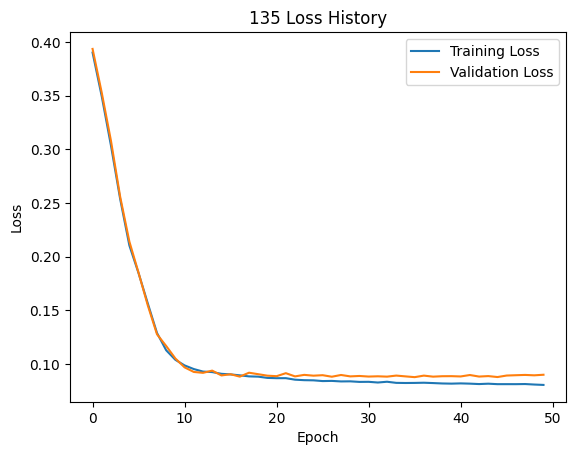

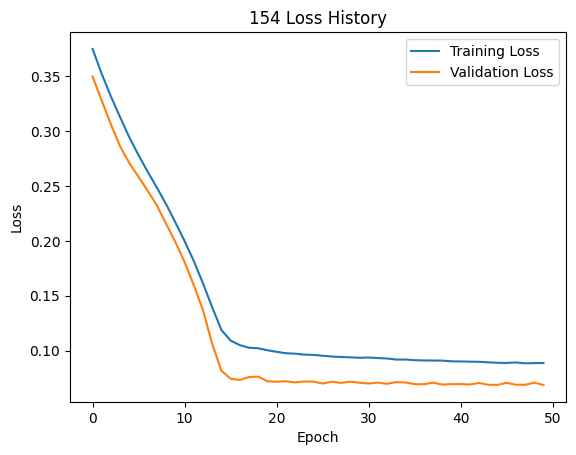

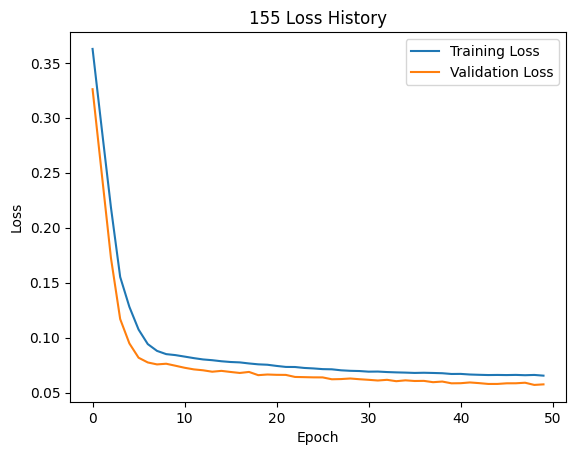

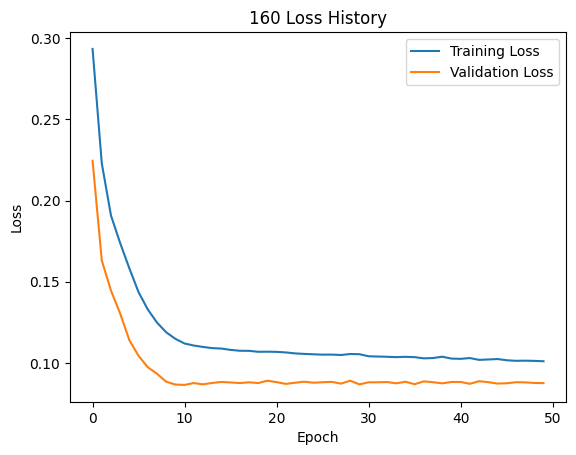

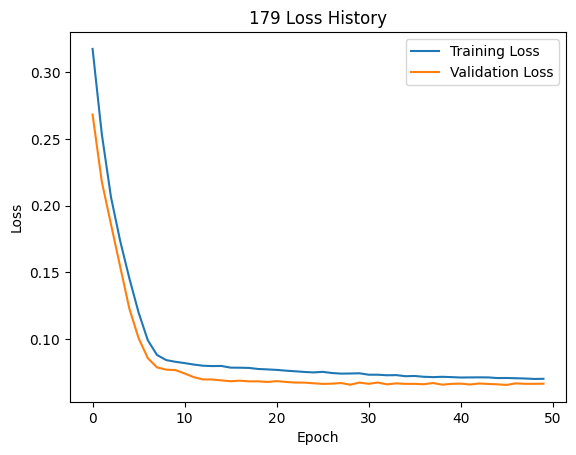

In [ ]:
from sklearn.model_selection import train_test_split
def create_regression_model(input_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(input_dim,)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(6)  # Output layer for regression, no activation function
    ])
    model.compile(optimizer='adam', loss='mae')  # Using Mean Squared Error for loss
    return model

regression_models = {}
for ann in lista_ann:
    scaler_X = MinMaxScaler()
    # scaler_y = MinMaxScaler()
    df_ma = df_ma2.loc[:, (slice(None), ann)].dropna()
    # y = scaler_y.fit_transform(df_ma.values)
    y = df_ma.values/10
    X = scaler_X.fit_transform(df_vars.loc[df_ma.index].values)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
    reg_model = create_regression_model(input_dim=len(fq_variables))
    history = reg_model.fit(X, y, epochs=50, batch_size=16, validation_split=0.2, verbose=0)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{ann} Loss History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    regression_models[ann] = reg_model

In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor

svr_models = {}
for ann in lista_ann:
    scaler_X = MinMaxScaler()
    # scaler_y = MinMaxScaler()
    df_ma = df_ma2.loc[:, (slice(None), ann)].dropna()
    # y = scaler_y.fit_transform(df_ma.values)
    y = df_ma.values/10
    X = scaler_X.fit_transform(df_vars.loc[df_ma.index].values)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    regressor = SVR()
    mor = MultiOutputRegressor(regressor)
    param_grid = [
        {'estimator__kernel': ['linear'], 'estimator__C': [0.1, 1, 10]},
        {'estimator__kernel': ['rbf'], 'estimator__C': [0.1, 1, 10], 'estimator__gamma': [0.1, 1, 10]},
        {'estimator__kernel': ['poly'], 'estimator__C': [0.1, 1, 10], 'estimator__degree': [2, 3, 4]}
    ]
    grid_search = GridSearchCV(mor, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
    # Perform hyperparameter tuning
    grid_search.fit(X_train, y_train)

    # Get the best model
    best_reg = grid_search.best_estimator_

    # Make predictions on the test set
    y_pred = best_reg.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    print(mae)
    svr_models[ann] = best_reg





/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


0.09699305005032698
0.08920966367914011
0.06611237830407657
0.09575417434797977
0.07039253965226716


In [ ]:
from sklearn.linear_model import ElasticNet
linear_models = {}
for ann in lista_ann:
    scaler_X = MinMaxScaler()
    # scaler_y = MinMaxScaler()
    df_ma = df_ma2.loc[:, (slice(None), ann)].dropna()
    # y = scaler_y.fit_transform(df_ma.values)
    y = df_ma.values/10
    X = scaler_X.fit_transform(df_vars.loc[df_ma.index].values)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    regressor = ElasticNet()
    mor = MultiOutputRegressor(regressor)
    param_grid = {
        'estimator__alpha': [0.1, 1, 10],
        'estimator__l1_ratio': [0.1, 0.5, 0.9]
    }
    grid_search = GridSearchCV(mor, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
    # Perform hyperparameter tuning
    grid_search.fit(X_train, y_train)

    # Get the best model
    best_reg = grid_search.best_estimator_

    # Make predictions on the test set
    y_pred = best_reg.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    print(mae)
    linear_models[ann] = best_reg

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


0.09439887152777778
0.08055349336318054
0.0700640125637297
0.10555011239377517
0.07394293924466339


In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor

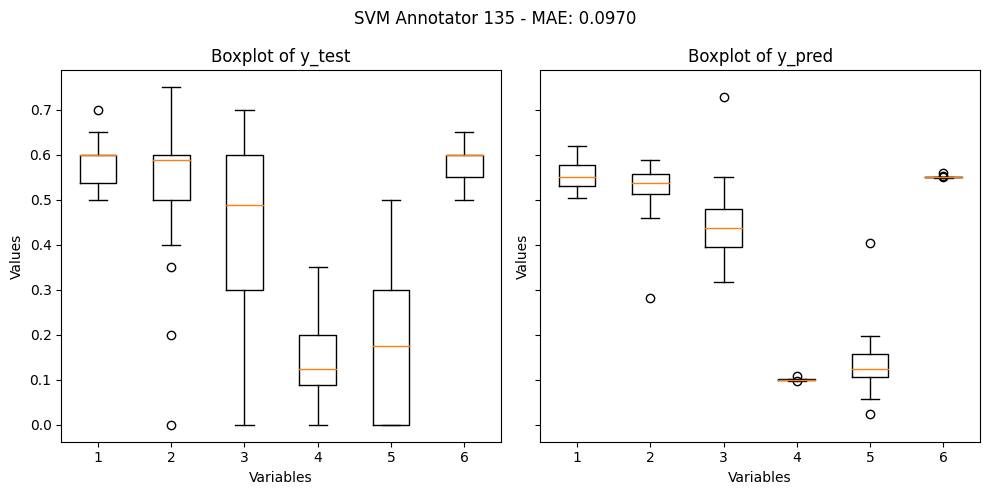

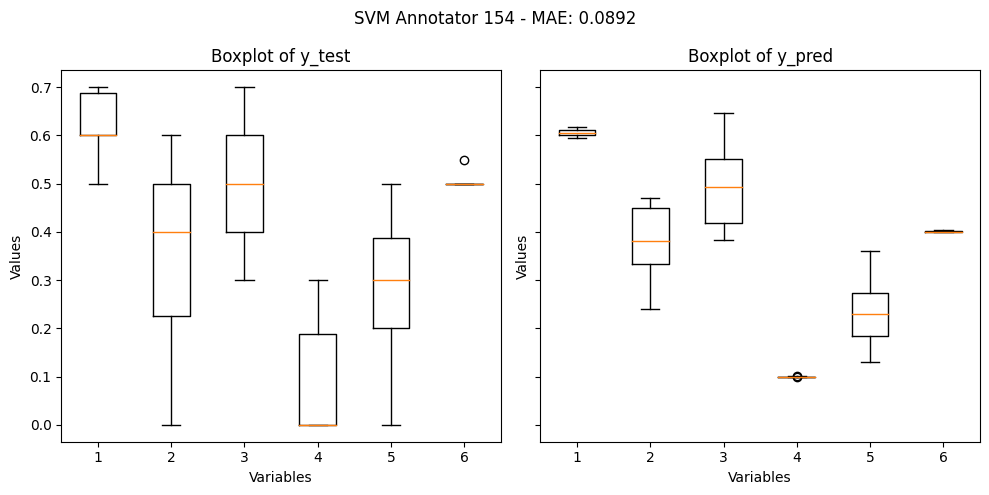

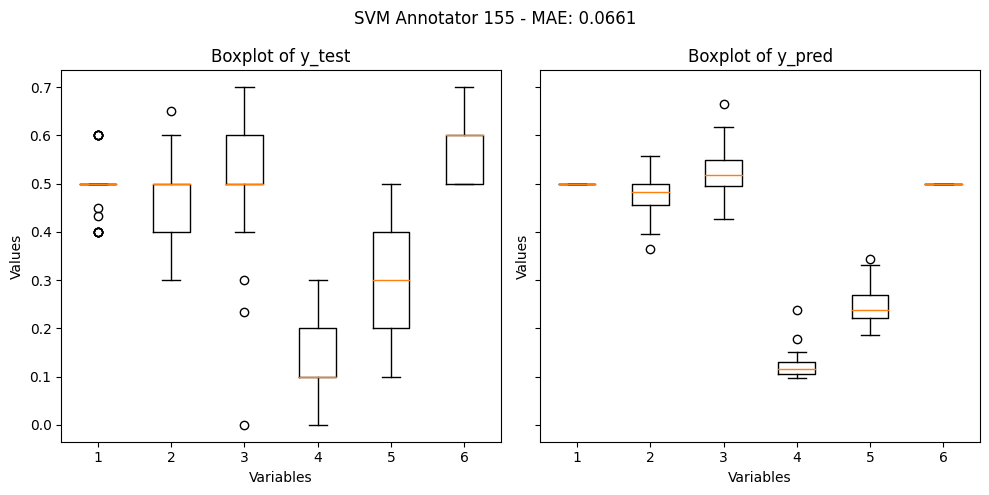

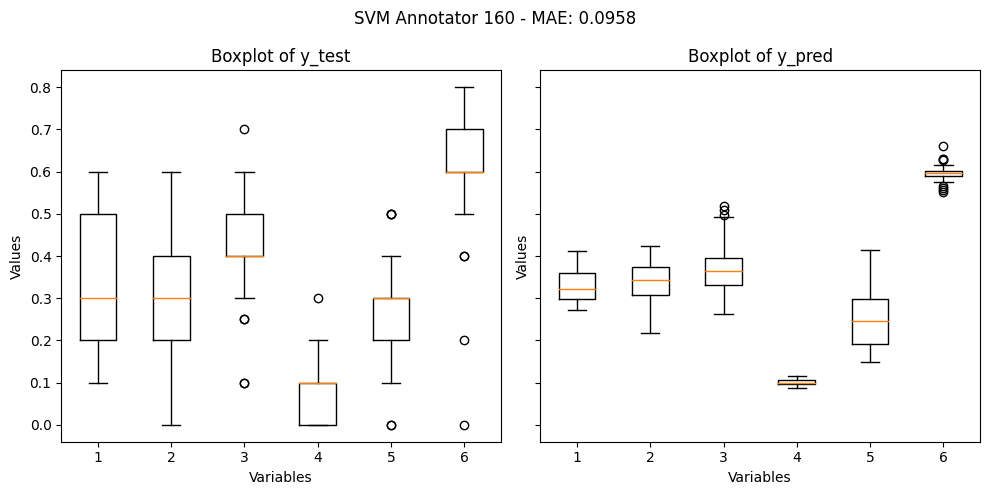

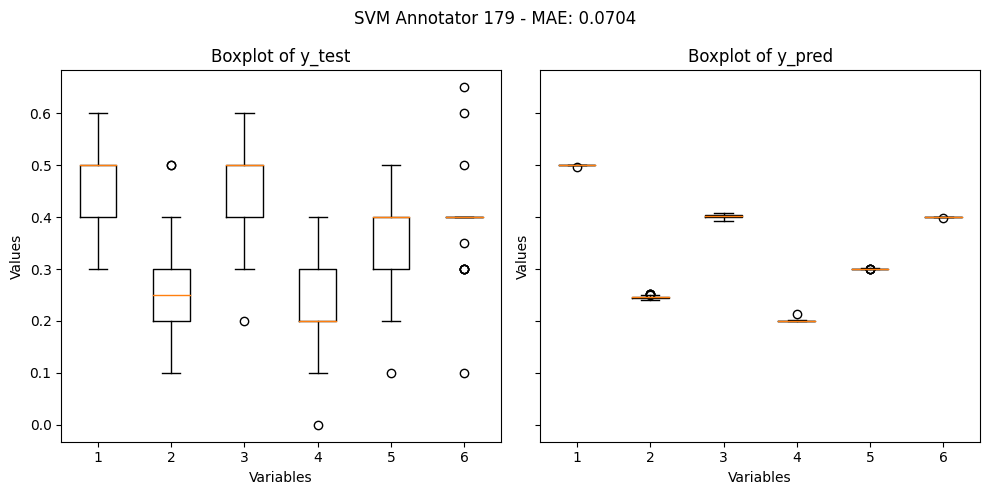

In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor

svr_models = {}
for ann in lista_ann:
    scaler_X = MinMaxScaler()
    # scaler_y = MinMaxScaler()
    df_ma = df_ma2.loc[:, (slice(None), ann)].dropna()
    # y = scaler_y.fit_transform(df_ma.values)
    y = df_ma.values/10
    X = scaler_X.fit_transform(df_vars.loc[df_ma.index].values)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    regressor = SVR()
    mor = MultiOutputRegressor(regressor)
    param_grid = [
        {'estimator__kernel': ['linear'], 'estimator__C': [0.1, 1, 10]},
        {'estimator__kernel': ['rbf'], 'estimator__C': [0.1, 1, 10], 'estimator__gamma': [0.1, 1, 10]},
        {'estimator__kernel': ['poly'], 'estimator__C': [0.1, 1, 10], 'estimator__degree': [2, 3, 4]}
    ]
    grid_search = GridSearchCV(mor, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
    # Perform hyperparameter tuning
    grid_search.fit(X_train, y_train)

    # Get the best model
    best_reg = grid_search.best_estimator_

    # Make predictions on the test set
    y_pred = best_reg.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharey=True)
    # Plot boxplot for y_train
    axes[0].boxplot(y_test)
    axes[0].set_title('Boxplot of y_test')
    axes[0].set_xlabel('Variables')
    axes[0].set_ylabel('Values')

    # Plot boxplot for y_pred
    axes[1].boxplot(y_pred)
    axes[1].set_title('Boxplot of y_pred')
    axes[1].set_xlabel('Variables')
    axes[1].set_ylabel('Values')

    # Adjust layout

    # Add title with MSE value
    plt.suptitle(f'SVM Annotator {ann} - MAE: {mae:.4f}')
    plt.tight_layout()
    svr_models[ann] = best_reg

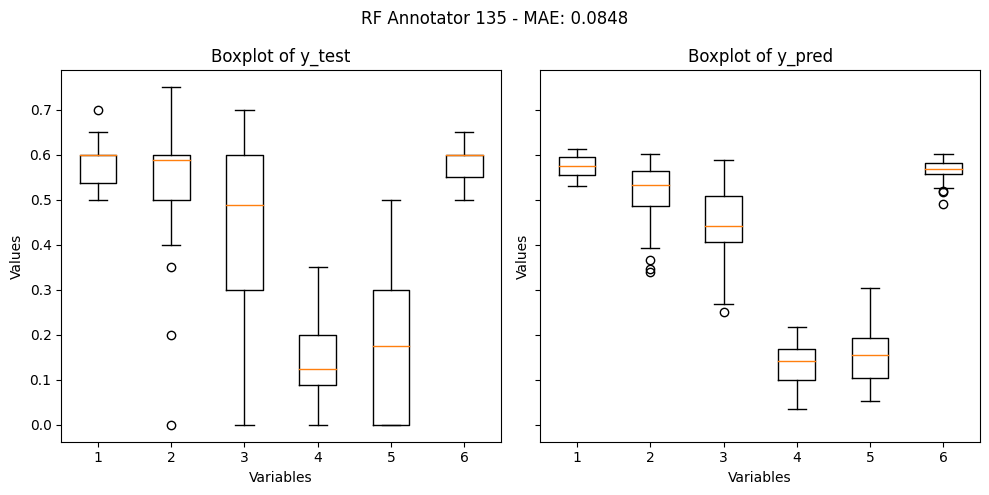

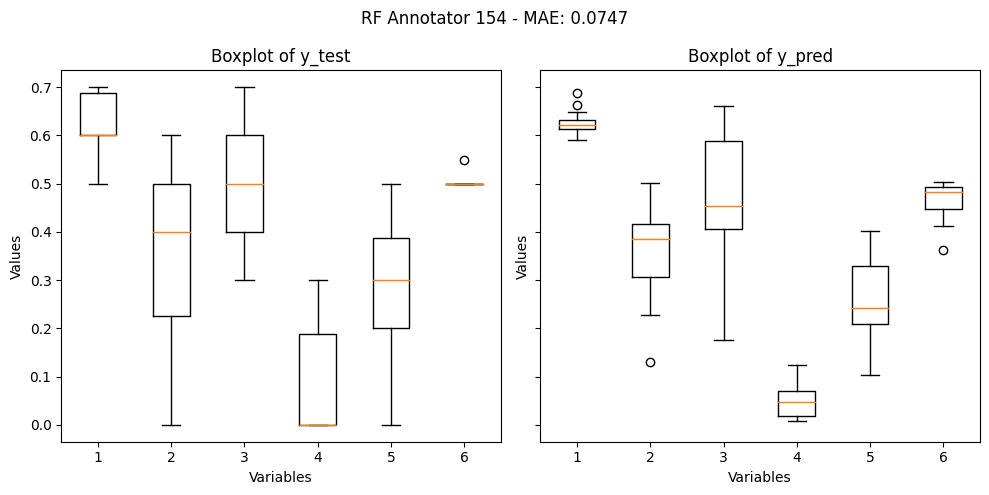

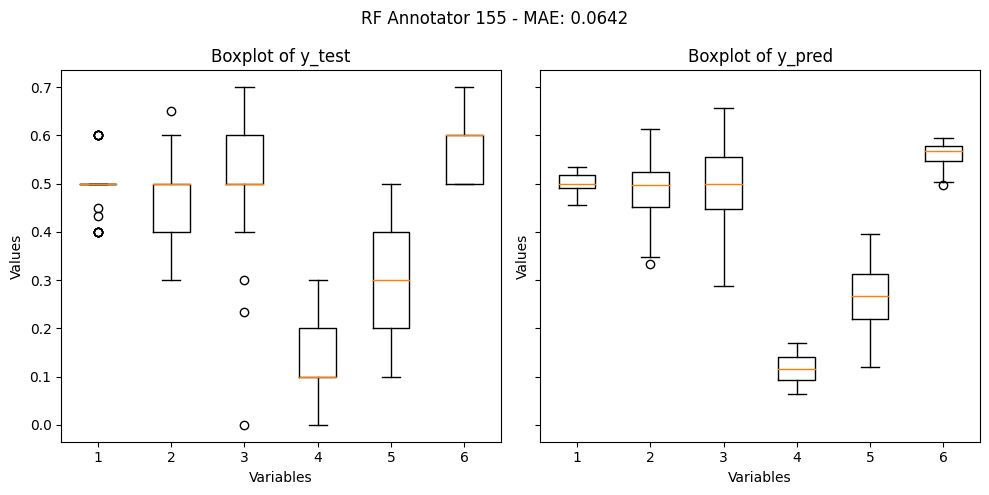

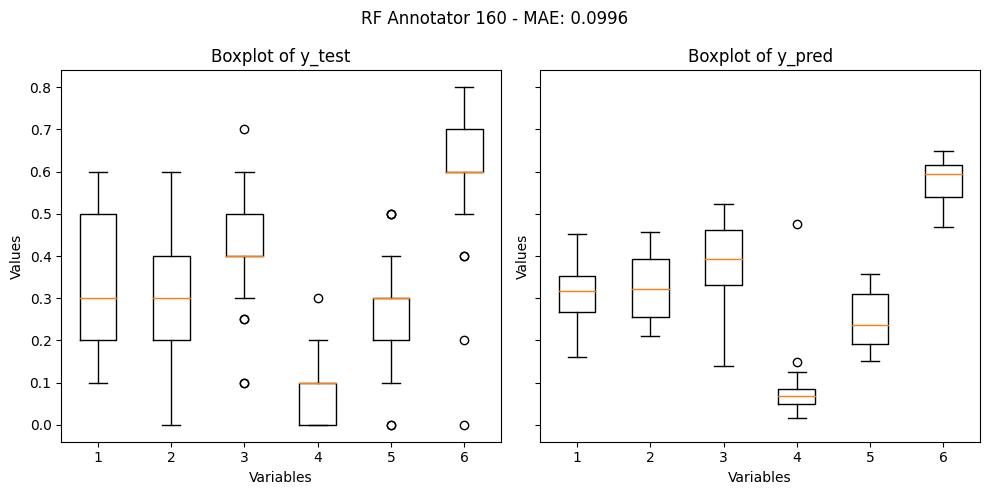

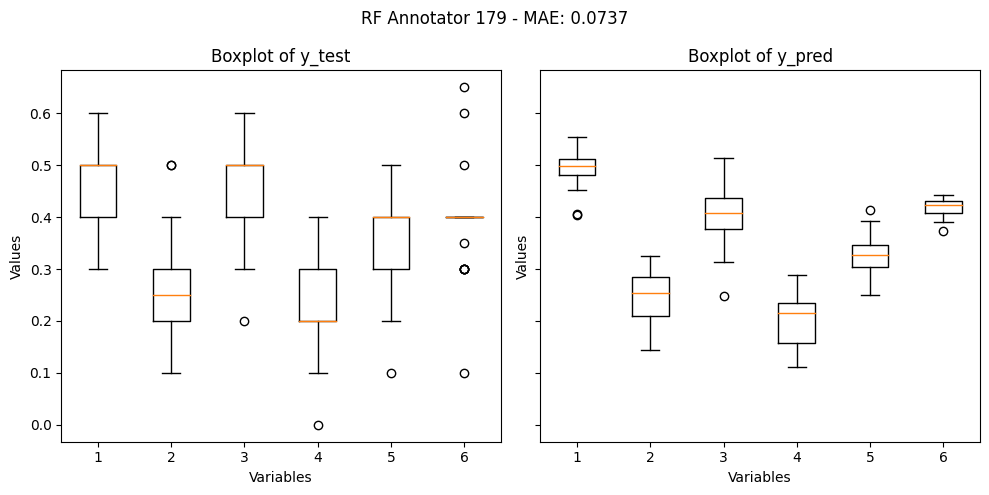

In [ ]:
from sklearn.ensemble import RandomForestRegressor
regression_models = {}
for ann in lista_ann:
    scaler_X = MinMaxScaler()
    # scaler_y = MinMaxScaler()
    df_ma = df_ma2.loc[:, (slice(None), ann)].dropna()
    # y = scaler_y.fit_transform(df_ma.values)
    y = df_ma.values/10
    X = scaler_X.fit_transform(df_vars.loc[df_ma.index].values)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    regressor = RandomForestRegressor()
    mor = MultiOutputRegressor(regressor)
    param_grid = {
        'estimator__n_estimators': [5, 10, 100],
        'estimator__max_depth': [None, 10, 20],
        'estimator__min_samples_split': [2, 5, 10]
    }
    grid_search = GridSearchCV(mor, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
    # Perform hyperparameter tuning
    grid_search.fit(X_train, y_train)

    # Get the best model
    best_reg = grid_search.best_estimator_

    # Make predictions on the test set
    y_pred = best_reg.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharey=True)
    # Plot boxplot for y_train
    axes[0].boxplot(y_test)
    axes[0].set_title('Boxplot of y_test')
    axes[0].set_xlabel('Variables')
    axes[0].set_ylabel('Values')

    # Plot boxplot for y_pred
    axes[1].boxplot(y_pred)
    axes[1].set_title('Boxplot of y_pred')
    axes[1].set_xlabel('Variables')
    axes[1].set_ylabel('Values')

    # Adjust layout

    # Add title with MSE value
    plt.suptitle(f'RF Annotator {ann} - MAE: {mae:.4f}')
    plt.tight_layout()
    regression_models[ann] = best_reg


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


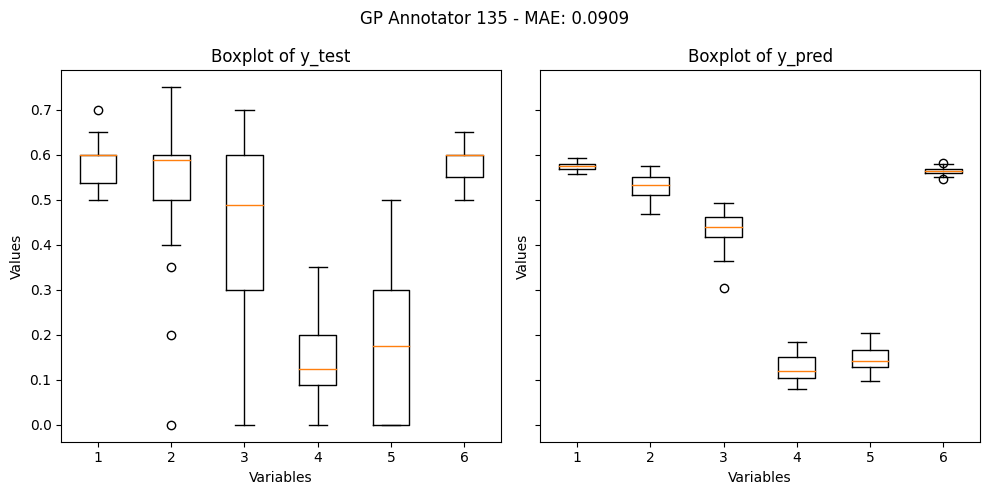

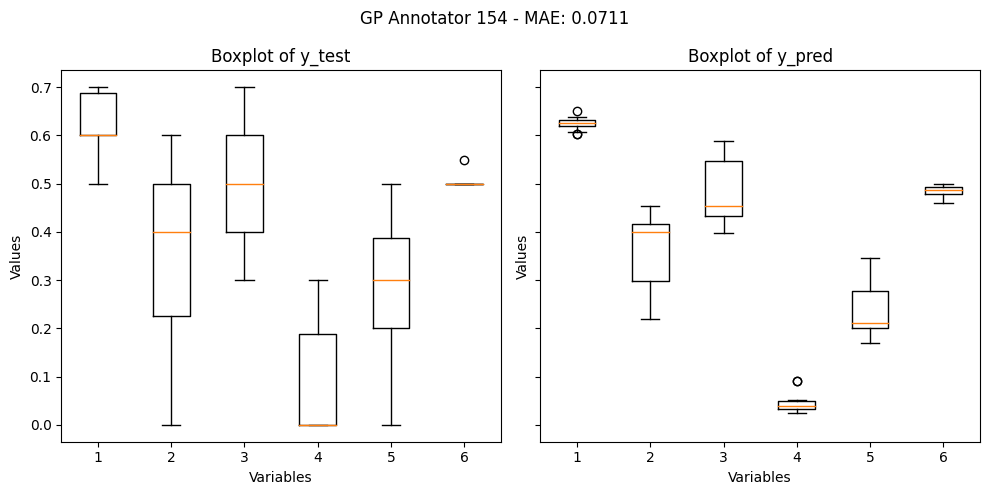

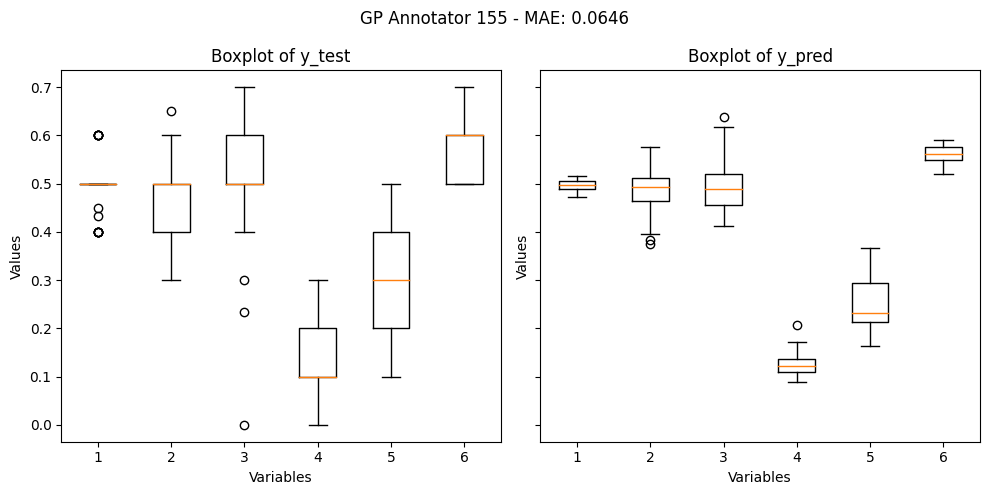

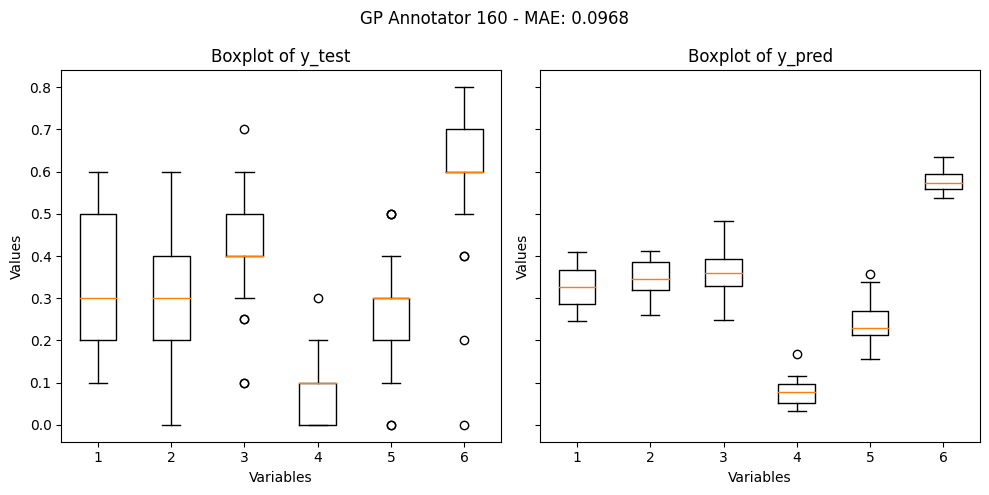

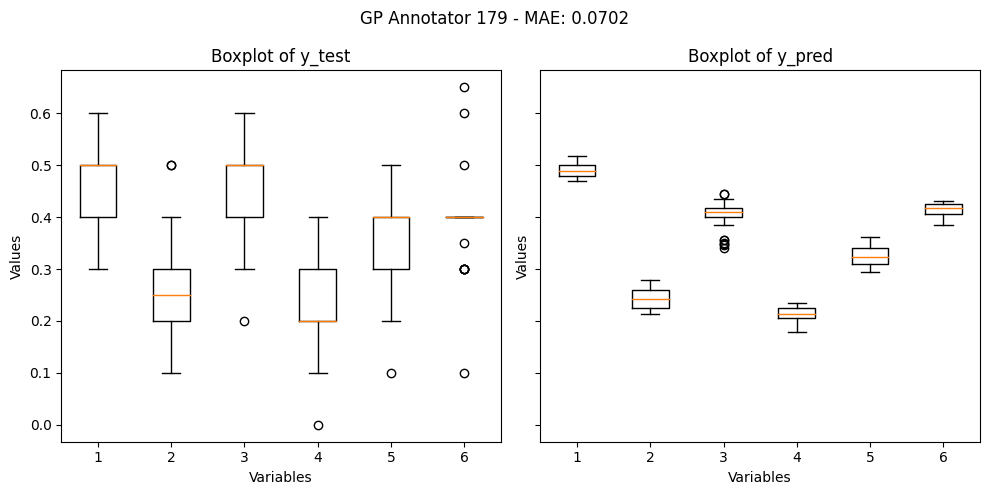

In [ ]:
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, ExpSineSquared, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor
gp_models = {}
for ann in lista_ann:
    scaler_X = MinMaxScaler()
    # scaler_y = MinMaxScaler()
    df_ma = df_ma2.loc[:, (slice(None), ann)].dropna()
    # y = scaler_y.fit_transform(df_ma.values)
    y = df_ma.values/10
    X = scaler_X.fit_transform(df_vars.loc[df_ma.index].values)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    regressor = GaussianProcessRegressor()
    kernels = [
        1.0 * RBF(),
        1.0 * Matern(),
        1.0 * RationalQuadratic(),
        # 1.0 * ExpSineSquared(),
        # WhiteKernel(),
        # Add more kernel options as needed
    ]

    # Define the param_grid dictionary with different kernel options
    param_grid = [{'kernel': kernels},
                  {'alpha': [1e-10]}]
    grid_search = GridSearchCV(regressor, param_grid, cv=20, scoring='neg_mean_absolute_error', n_jobs=-1)
    # Perform hyperparameter tuning
    grid_search.fit(X_train, y_train)

    # Get the best model
    best_reg = grid_search.best_estimator_

    # Make predictions on the test set
    y_pred = best_reg.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharey=True)

    # Plot boxplot for y_train
    axes[0].boxplot(y_test)
    axes[0].set_title('Boxplot of y_test')
    axes[0].set_xlabel('Variables')
    axes[0].set_ylabel('Values')

    # Plot boxplot for y_pred
    axes[1].boxplot(y_pred)
    axes[1].set_title('Boxplot of y_pred')
    axes[1].set_xlabel('Variables')
    axes[1].set_ylabel('Values')

    # Adjust layout

    # Add title with MSE value
    plt.suptitle(f'GP Annotator {ann} - MAE: {mae:.4f}')
    plt.tight_layout()
    gp_models[ann] = best_reg

## GP by annotator
### Train models

In [ ]:
lista_ann

['135', '154', '155', '160', '179']

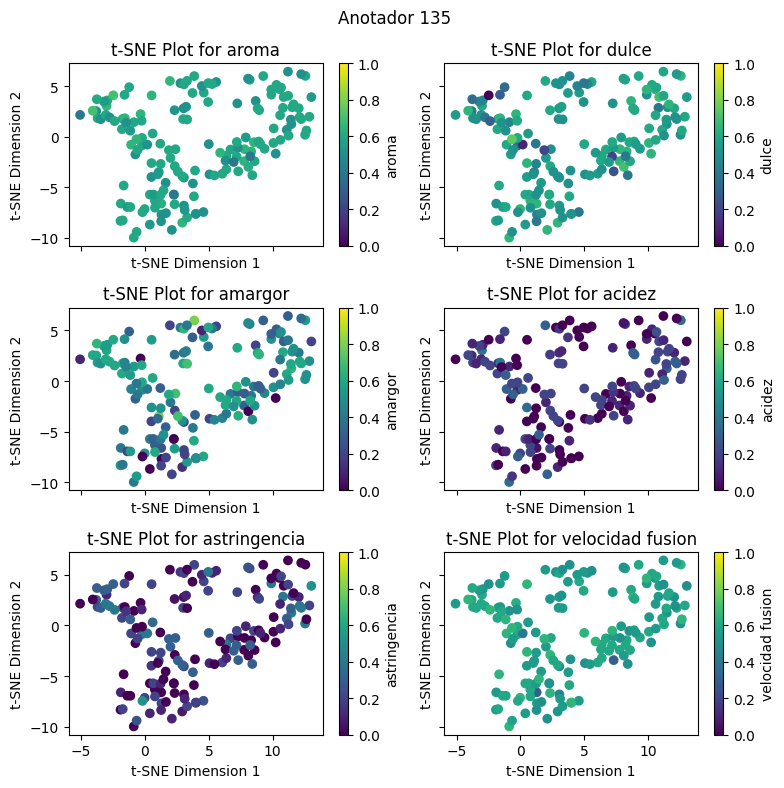

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


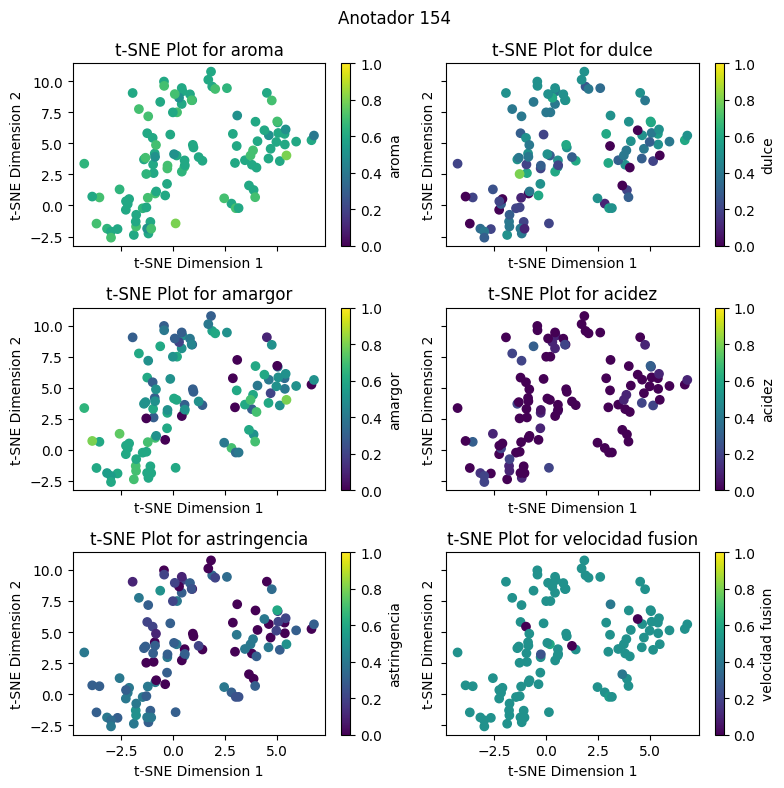

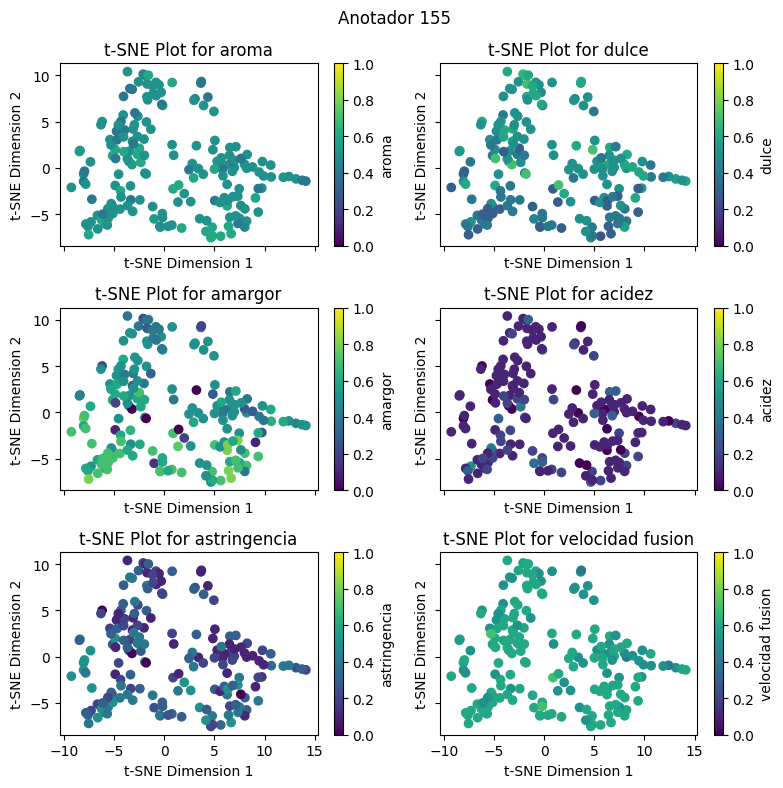

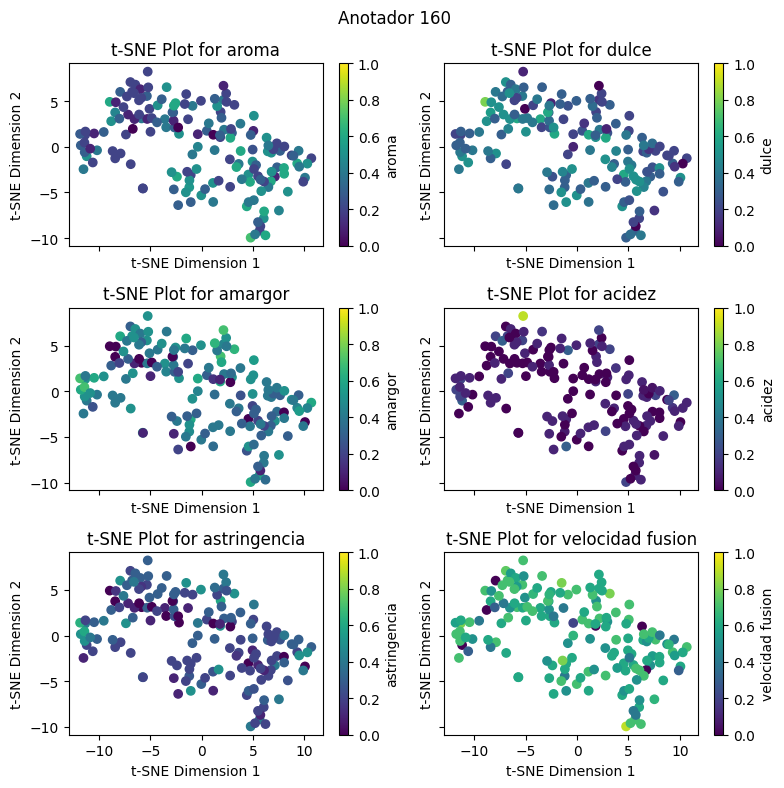

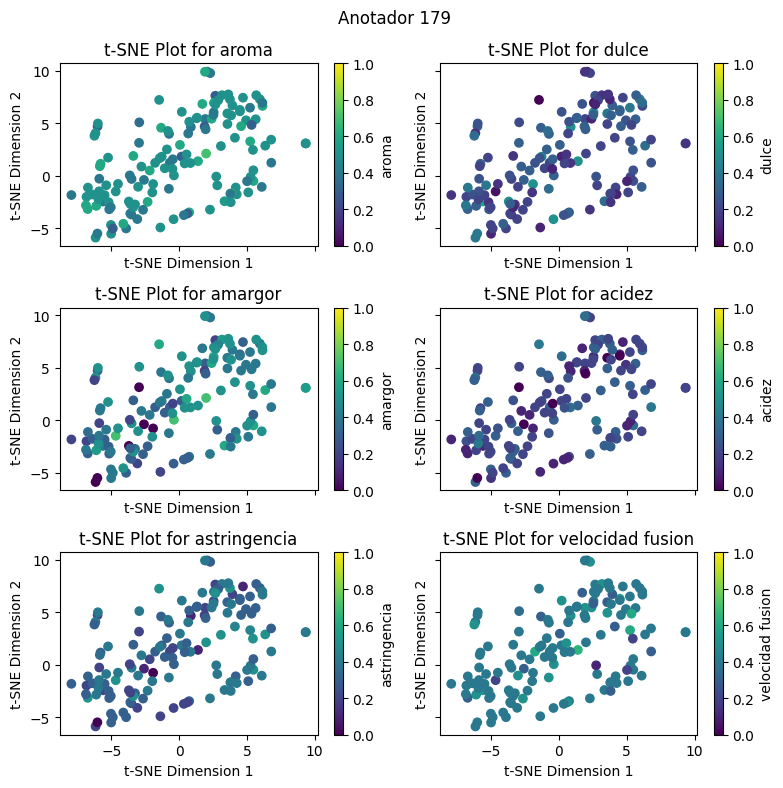

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, DotProduct, Matern, RationalQuadratic, ExpSineSquared
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.exceptions import ConvergenceWarning

# Ignore all convergence warnings
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
gp_vars_tot = {}
for ann in lista_ann:
    df_ma = df_ma2.loc[:, (slice(None), ann)].dropna()
    y = df_ma.values/10
    scaler_X = MinMaxScaler()
    X = scaler_X.fit_transform(df_vars.loc[df_ma.index].values)
    tsne = TSNE(2)
    X_red = tsne.fit_transform(X)
    fig, axs = plt.subplots(3, 2, sharex=True, sharey=True, figsize=(8,8))
    axs = axs.flatten()
    for i in range(6):
        sc = axs[i].scatter(*X_red.T, c=y[:,i], vmin=0, vmax=1)
        axs[i].set_title(f't-SNE Plot for {variables[i]}')
        axs[i].set_xlabel('t-SNE Dimension 1')
        axs[i].set_ylabel('t-SNE Dimension 2')
        fig.colorbar(sc, ax=axs[i], label=f'{variables[i]}')
    fig.suptitle(f'Anotador {ann}')
    plt.tight_layout()
    plt.show()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    gp_vars = {}
    cons_params = {'constant_value': 1.0,
                'constant_value_bounds':(1e-10, 100.0)}
    for i, var in enumerate(variables):
        y_train_var, y_test_var = y_train[:,i], y_test[:,i]
        regressor = GaussianProcessRegressor()
        kernels = [
            ConstantKernel(**cons_params) * RBF([1,1,1,1,1], [1e-20,100]) + \
            ConstantKernel(**cons_params) * DotProduct(),
            # ConstantKernel(**cons_params) * Matern(),
            # ConstantKernel(**cons_params) * Matern(nu=0.5),
            # ConstantKernel(**cons_params) * Matern(nu=2),
            # ConstantKernel(**cons_params) * Matern(nu=4)
            # ConstantKernel(**cons_params) * ExpSineSquared()
        ]

        # Define the param_grid dictionary with different kernel options
        param_grid = {'kernel': kernels}

        grid_search = GridSearchCV(regressor, param_grid, cv=20, scoring=['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_absolute_percentage_error'],
                                n_jobs=-1, refit='neg_mean_absolute_error')
        # Perform hyperparameter tuning
        grid_search.fit(X_train, y_train_var)

        # Get the best model
        best_reg = grid_search.best_estimator_

        # Make predictions on the test set
        y_pred = best_reg.predict(X_test)
        mae = mean_absolute_error(y_test_var, y_pred)
        gp_vars[var] = grid_search
    gp_vars_tot[ann] = gp_vars

### Kernels

In [ ]:
# for var in variables:
#     print(df_ma2.loc[:,(var, ann)].value_counts())

In [ ]:
gp_vars_tot[ann]['astringencia'].cv_results_

{'mean_fit_time': array([0.13885932]),
 'std_fit_time': array([0.06636651]),
 'mean_score_time': array([0.00258864]),
 'std_score_time': array([0.00099594]),
 'param_kernel': masked_array(data=[1**2 * RBF(length_scale=[1, 1, 1, 1, 1]) + 1**2 * DotProduct(sigma_0=1)],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'kernel': 1**2 * RBF(length_scale=[1, 1, 1, 1, 1]) + 1**2 * DotProduct(sigma_0=1)}],
 'split0_test_neg_mean_absolute_error': array([-0.10042725]),
 'split1_test_neg_mean_absolute_error': array([-0.06627401]),
 'split2_test_neg_mean_absolute_error': array([-0.07601522]),
 'split3_test_neg_mean_absolute_error': array([-0.06873372]),
 'split4_test_neg_mean_absolute_error': array([-0.08603822]),
 'split5_test_neg_mean_absolute_error': array([-0.0761556]),
 'split6_test_neg_mean_absolute_error': array([-0.10193278]),
 'split7_test_neg_mean_absolute_error': array([-0.07897949]),
 'split8_test_neg_mean_absolute_error': array([-0.07881266]

In [ ]:
for ann in lista_ann:
    for var in variables:
        print('*'*10 + f'{ann}_{var}' + '*'*10)
        print(gp_vars_tot[ann][var].best_estimator_.kernel_)
        # Extracting values from gp_vars[var].cv_results_
        cv_results = gp_vars_tot[ann][var].cv_results_
        mae_mean = cv_results['mean_test_neg_mean_absolute_error'][0]
        mae_std = cv_results['std_test_neg_mean_absolute_error'][0]
        mse_mean = cv_results['mean_test_neg_mean_squared_error'][0]
        mse_std = cv_results['std_test_neg_mean_squared_error'][0]

        # Creating a DataFrame
        data = {
            'Measure': ['MAE', 'MSE'],
            'Mean': [mae_mean, mse_mean],
            'Std': [mae_std, mse_std]
        }
        df = pd.DataFrame(data)
        # Setting 'Measure' column as index
        df.set_index('Measure', inplace=True)

        # Displaying the DataFrame
        print(df)
        print()

**********135_aroma**********
0.0568**2 * RBF(length_scale=[1e-20, 1e-20, 1e-20, 1e-20, 1e-20]) + 0.000753**2 * DotProduct(sigma_0=762)
             Mean       Std
Measure                    
MAE     -0.049039  0.014206
MSE     -0.003664  0.002518

**********135_dulce**********
0.303**2 * RBF(length_scale=[1e-20, 1e-20, 1e-20, 1e-20, 1e-20]) + 8.74**2 * DotProduct(sigma_0=8.55e+04)
             Mean       Std
Measure                    
MAE     -0.068011  0.017332
MSE     -0.008485  0.005647

**********135_amargor**********
0.168**2 * RBF(length_scale=[1e-20, 1e-20, 1e-20, 1e-20, 1e-20]) + 0.169**2 * DotProduct(sigma_0=1.58)
             Mean       Std
Measure                    
MAE     -0.141766  0.040207
MSE     -0.032022  0.019323

**********135_acidez**********
0.109**2 * RBF(length_scale=[1e-20, 1e-20, 1e-20, 1e-20, 1e-20]) + 0.000217**2 * DotProduct(sigma_0=520)
             Mean       Std
Measure                    
MAE     -0.092936  0.021549
MSE     -0.011658  0.005263

*****

In [ ]:
gp_vars['acidez'].best_estimator_.kernel_(X,X)

array([[0.00635054, 0.00142607, 0.00142611, ..., 0.00142616, 0.00142623,
        0.00142612],
       [0.00142607, 0.00635046, 0.00142617, ..., 0.00142615, 0.00142612,
        0.00142619],
       [0.00142611, 0.00142617, 0.00635044, ..., 0.00142617, 0.00142611,
        0.00142617],
       ...,
       [0.00142616, 0.00142615, 0.00142617, ..., 0.00635044, 0.00142615,
        0.00142617],
       [0.00142623, 0.00142612, 0.00142611, ..., 0.00142615, 0.0063505 ,
        0.00142615],
       [0.00142612, 0.00142619, 0.00142617, ..., 0.00142617, 0.00142615,
        0.00635046]])

In [ ]:
gp_vars_tot[ann]['aroma'].best_estimator_.kernel_(X,X).max()

0.2440373995297723

In [ ]:
for ann in lista_ann:
    df_ma = df_ma2.loc[:, (slice(None), ann)].dropna()
    y = df_ma.values/10
    scaler_X = MinMaxScaler()
    X = scaler_X.fit_transform(df_vars.loc[df_ma.index].values)
    fig, axs = plt.subplots(2, 3, figsize=(9,6), sharex=True, sharey=True)
    fig.suptitle(f'Anotador {ann}')
    axs = axs.flatten()
    for idx, var in enumerate(variables):
        ax = axs[idx]
        im = ax.imshow(gp_vars_tot[ann][var].best_estimator_.kernel_(X, X))
        # fig.colorbar(im, ax=ax)
        ax.set_title(f'{var}')
    plt.tight_layout()
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

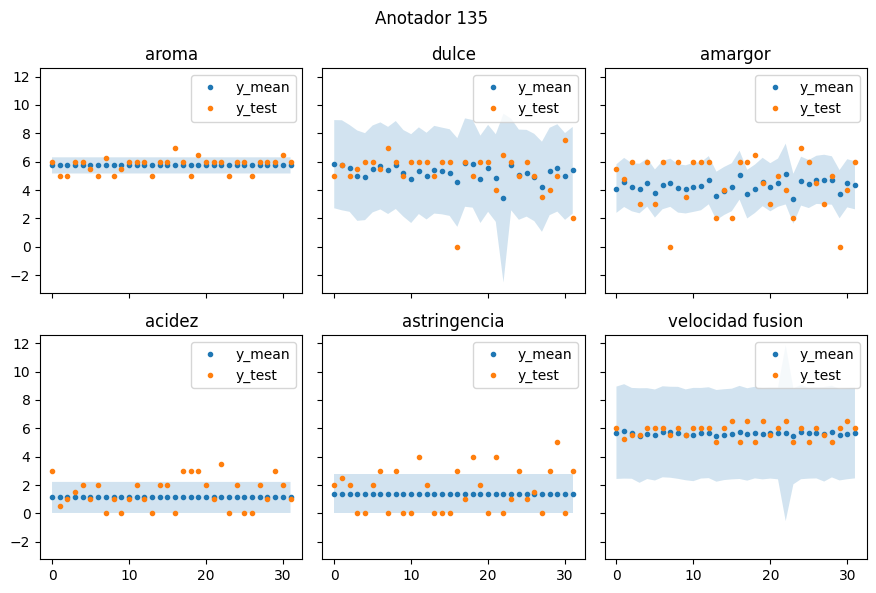

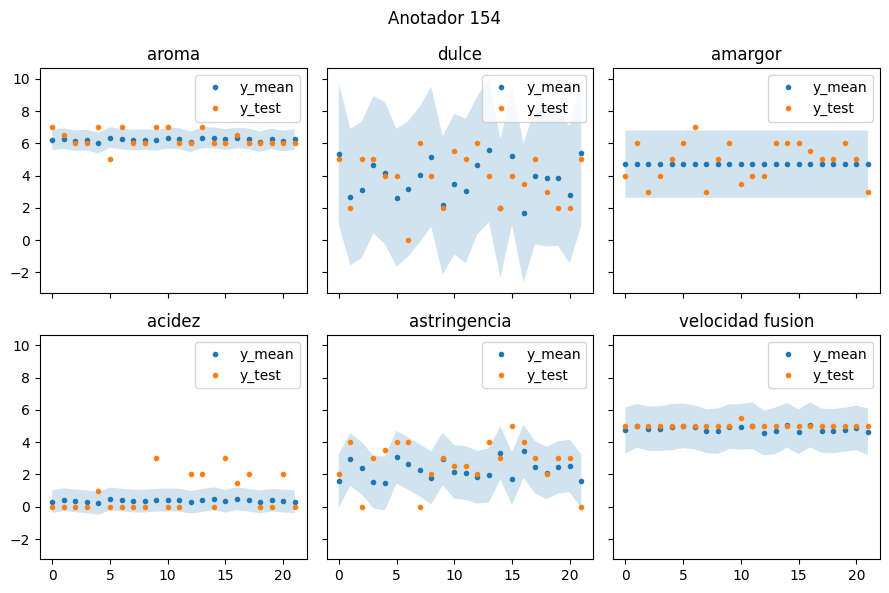

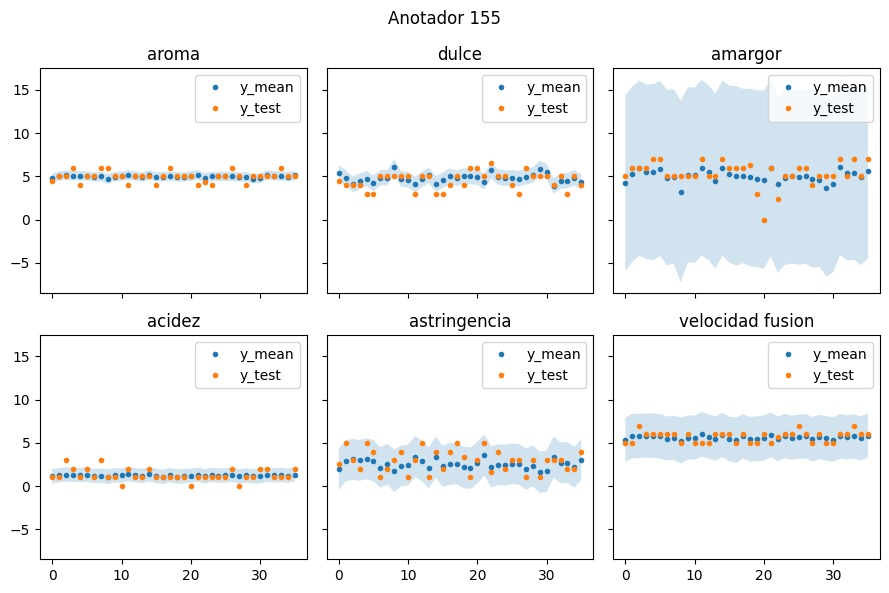

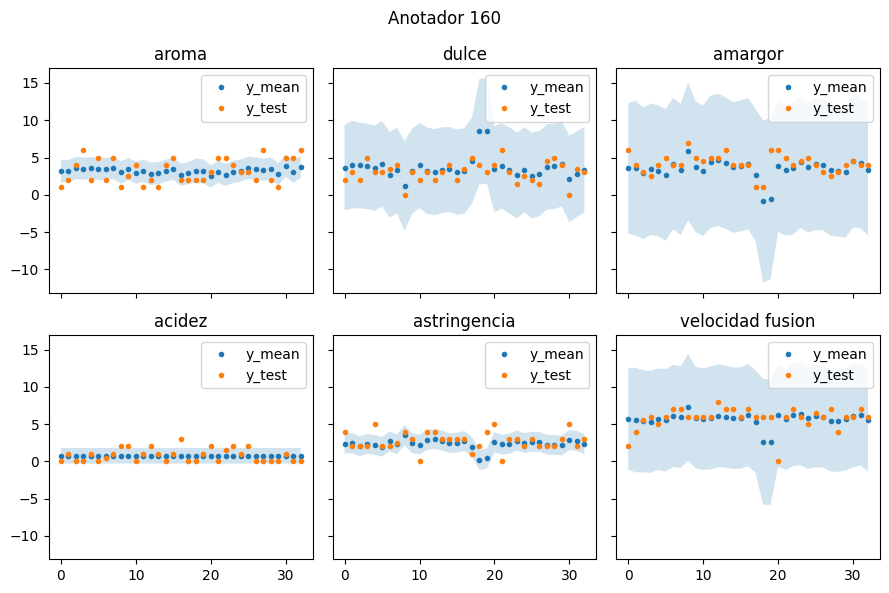

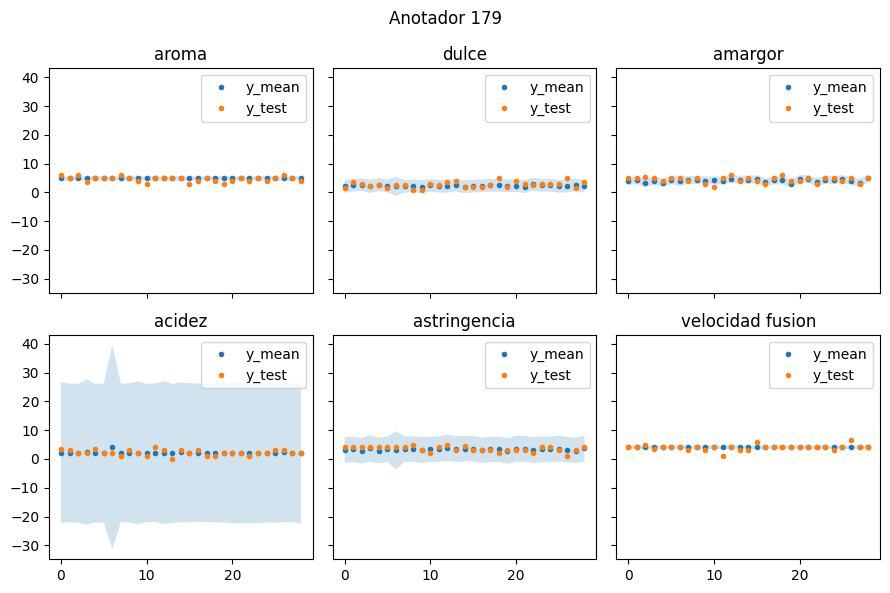

In [ ]:
for ann in lista_ann:
    df_ma = df_ma2.loc[:, (slice(None), ann)].dropna()
    y = df_ma.values #/10
    scaler_X = MinMaxScaler()
    X = scaler_X.fit_transform(df_vars.loc[df_ma.index].values)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    fig, axs = plt.subplots(2, 3, figsize=(9,6), sharey=True, sharex=True)
    fig.suptitle(f'Anotador {ann}')
    axs = axs.flatten()
    for idx, var in enumerate(variables):
        ax = axs[idx]
        y_mean, y_std = gp_vars_tot[ann][var].best_estimator_.predict(X_test, return_std=True)
        y_mean *= 10
        y_std *= 10
        ax.plot(y_mean, '.', label='y_mean')
        ax.plot(y_test[:,idx], '.', label='y_test')
        ax.fill_between(range(len(X_test)), y_mean - y_std, y_mean + y_std, alpha=0.2)
        # fig.colorbar(im, ax=ax)
        ax.set_title(f'{var}')
        ax.legend()
    plt.tight_layout()
    plt.show()


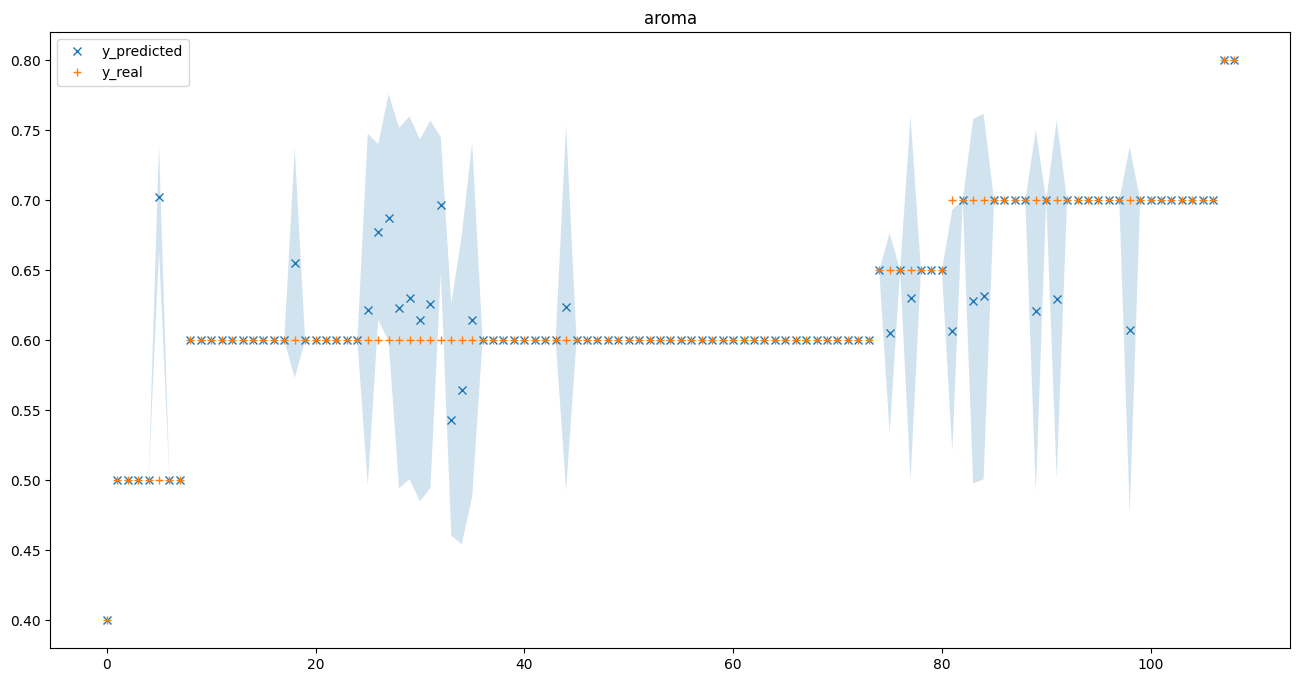

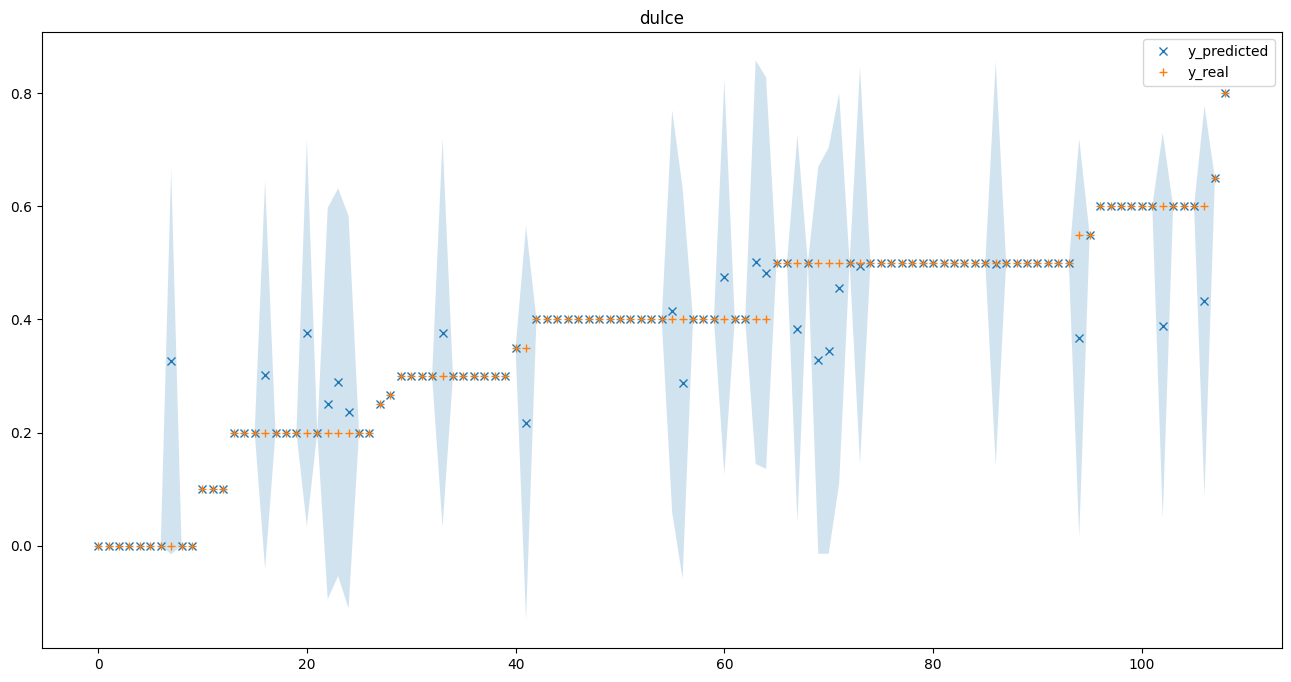

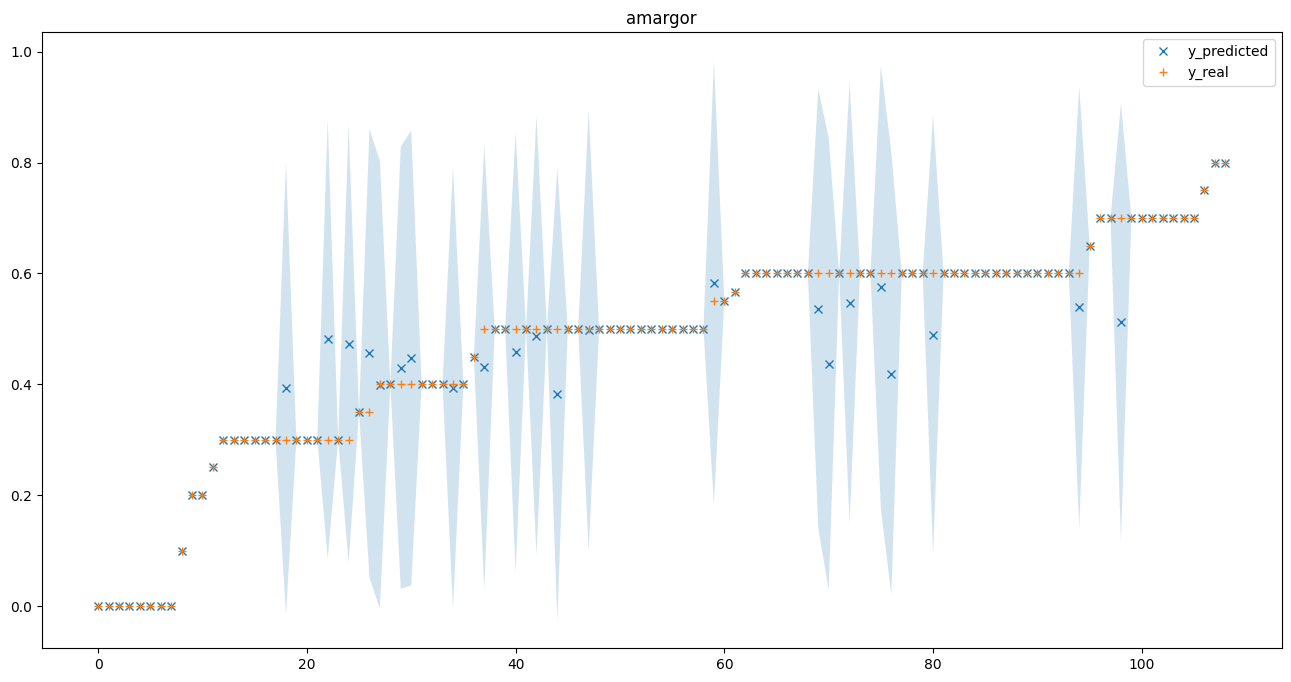

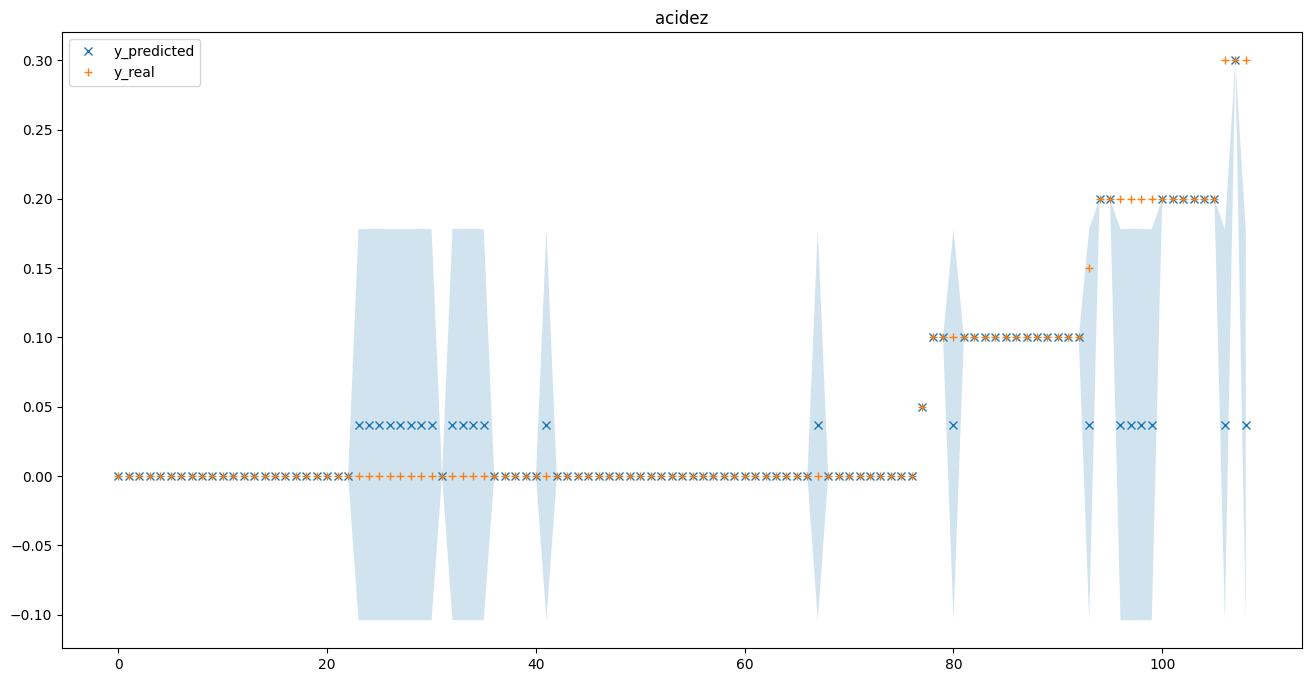

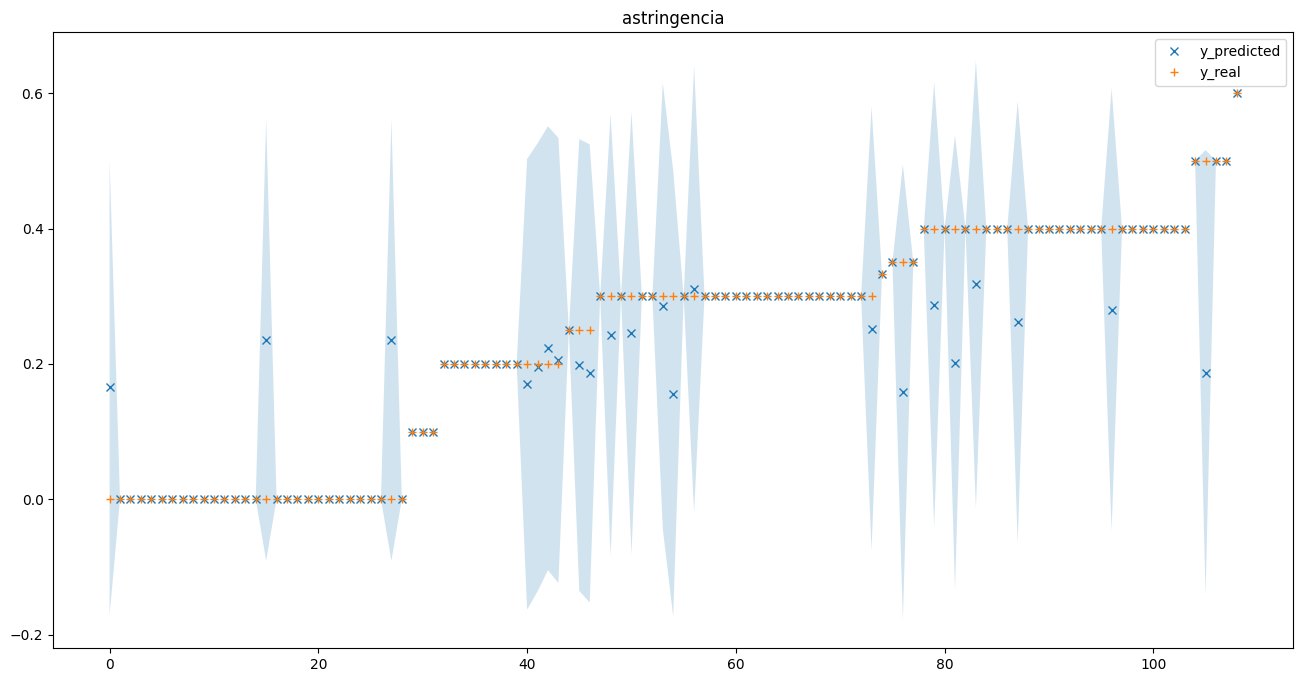

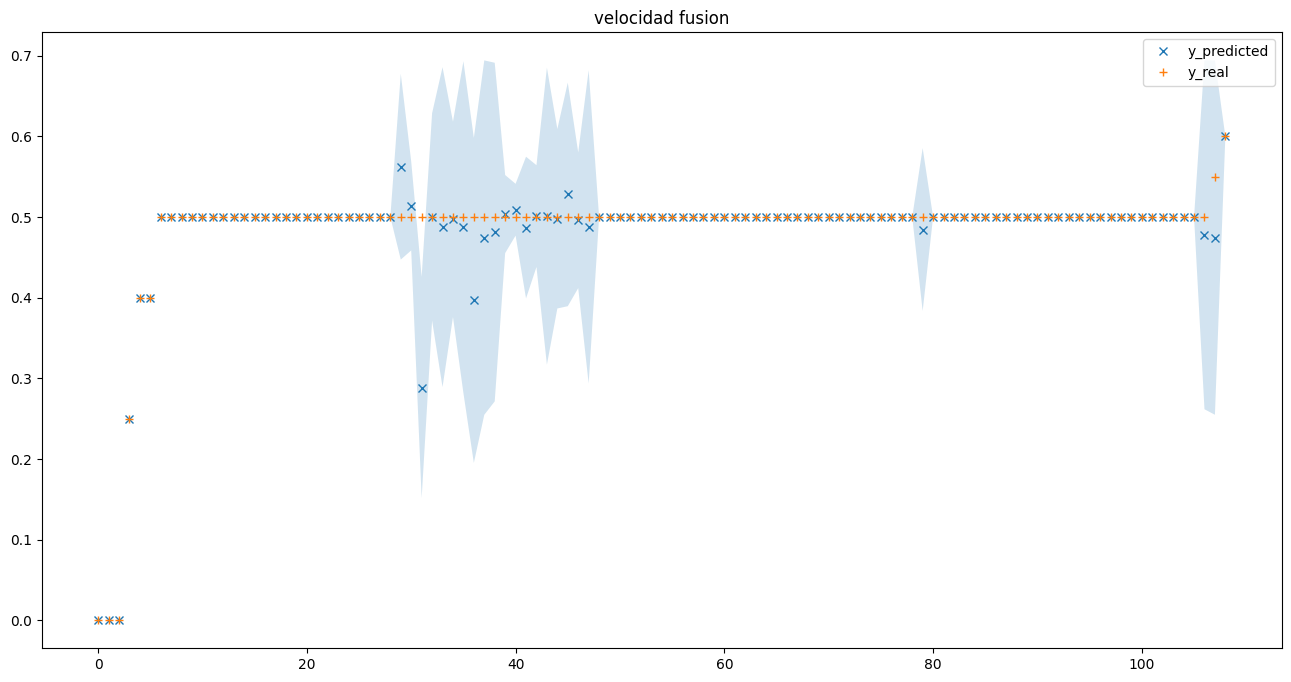

In [ ]:
for i, var in enumerate(variables):
    X_ = np.concatenate([X_train, X_test])
    y_ = np.concatenate([y_train[:,i], y_test[:,i]])
    idx = np.argsort(y_)
    y_mean, y_std = gp_vars[var].best_estimator_.predict(X_, return_std=True)
    plt.figure(figsize=(16,8))
    n_train = len(X_train)
    plt.plot(y_mean[idx], 'x', label='y_predicted')
    plt.plot(range(len(y_)), y_[idx], '+', label='y_real')
    # plt.plot(np.sort(idx[n_train:]), y_[idx[n_train:]], '+')
    # plt.plot(idx[:len(y_train)], y_[idx[:len(y_train)]], '+', label='y_train')
    # plt.plot(idx[-len(y_test):], y_[idx[-len(y_test):]], '+', label='y_test')
    plt.fill_between(range(len(idx)), y_mean[idx] - 2*y_std[idx], y_mean[idx] + 2*y_std[idx], alpha=0.2)
    plt.title(f'{var}')
    plt.legend()
    plt.show()

In [ ]:
a = best_reg

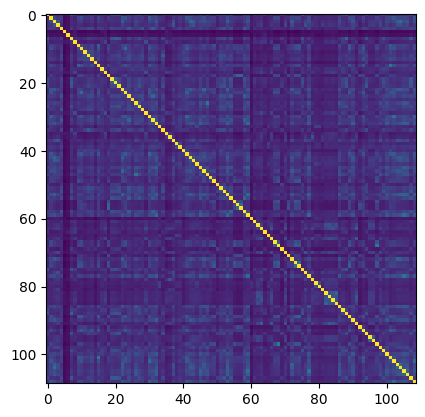

In [ ]:
plt.imshow(a.kernel_(X,X))

In [ ]:
grid_search.cv_results_

{'mean_fit_time': array([0.24789767, 0.12204791, 0.27346984, 0.257055  ]),
 'std_fit_time': array([0.06497195, 0.05107082, 0.07204438, 0.0547245 ]),
 'mean_score_time': array([0.00377702, 0.00355996, 0.00269126, 0.00389094]),
 'std_score_time': array([0.00385973, 0.00298965, 0.00242178, 0.00525365]),
 'param_kernel': masked_array(data=[1**2 * RBF(length_scale=1),
                    1**2 * Matern(length_scale=1, nu=1.5),
                    1**2 * RationalQuadratic(alpha=1, length_scale=1),
                    1**2 * RationalQuadratic(alpha=1, length_scale=1)],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_alpha': masked_array(data=[--, --, --, 1e-06],
              mask=[ True,  True,  True, False],
        fill_value='?',
             dtype=object),
 'params': [{'kernel': 1**2 * RBF(length_scale=1)},
  {'kernel': 1**2 * Matern(length_scale=1, nu=1.5)},
  {'kernel': 1**2 * RationalQuadratic(alpha=1, length_scale=1)},
  {'a

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# Iterate over the range of number of clusters
X = df_vars.values
silhouette_scores = []
for n_clusters in range(2,20):
    # Create a KMeans instance with the current number of clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    # Fit the KMeans model to the data
    cluster_labels = kmeans.fit_predict(X)
    # Calculate the silhouette score
    silhouette_avg = silhouette_score(X, cluster_labels)
    # Append the silhouette score to the list
    silhouette_scores.append(silhouette_avg)

In [ ]:
silhouette_scores

[0.7147298596782319,
 0.5551582581141009,
 0.3996018314516818,
 0.2812795714848881,
 0.3399969763390662,
 0.3136824065908736,
 0.33002893088526103,
 0.32859118497838036,
 0.3360029608811005,
 0.3241207353127662,
 0.32023767101565703,
 0.29154337887149756,
 0.2837322635976085,
 0.27241830275169215,
 0.27435079039026405,
 0.27372958230793715,
 0.28104152620503514,
 0.2888033312944409]

# CKA Regressor

In [ ]:
def CKARegressor(regression_models, models_CKA, X):
    mu_matrix = np.array([models_CKA[var].mu.numpy().flatten() for var in variables])
    mu_matrix /= np.sum(mu_matrix, axis=1)[:,np.newaxis]
    output = np.zeros((len(X), 6))
    for i in range(len(regression_models)):
        pred = regression_models[lista_ann[i]].predict(X)
        output += pred*mu_matrix[:,i]
    return output

# LCKA Regressor

In [ ]:
df_vars, df_ma2, anotadores = create_dfs(df_comb.copy(), fq_variables, variables, 5, 'all')
scaler_X = MinMaxScaler()
X = scaler_X.fit_transform(df_vars.values)
for var in variables:
    df_ma = df_ma2[var]
    anotadores = lista_ann
    df_ma = df_ma.loc[:, anotadores]
    y = df_ma.values/10
    iAnn = get_iAnn(y)
    models_LCKA2[var].X = X
    models_LCKA2[var].iAnn = iAnn

In [ ]:
m = models_LCKA2['velocidad fusion']
(m.get_new_q2(X,iAnn,X[:1]) * np.array([regression_models[ann].predict(X[:1])[0][-1] for ann in lista_ann])).sum()/m.get_new_q2(X,iAnn,X[:1]).sum()

1/1 [==============================] - 0s 115ms/step


0.48828321426126575

In [ ]:
m.get_new_q2(X,iAnn,X[:1])

array([[0.03023871, 0.03761244, 0.19037836, 0.15927332, 0.13629964]])

In [ ]:
def LCKARegressor(regression_models, models_LCKA, X):
    # Q: variables x samples x annotators
    Q = np.array([models_LCKA2[var].get_new_q2(models_LCKA2[var].X, models_LCKA2[var].iAnn, X) for var in variables])
    output = np.zeros((len(X), 6))
    for i in range(len(regression_models)):
        # samples x variables
        pred = regression_models[lista_ann[i]].predict(X)
        # Q_ann : variables x samples, Q_ann.T : samples x varialbes
        Q_ann = Q[:, :, i].T
        output += pred * Q_ann
    output /= Q.sum(axis=2).T
    return output

In [ ]:
pred = LCKARegressor(regression_models, models_LCKA2, X[:1])

1/1 [==============================] - 0s 66ms/step


In [ ]:
pred

array([[0.11630268, 0.42351918, 0.43118309, 0.24222851, 0.34270525,
        0.48828321]])

In [ ]:
[regression_models[ann].predict(X[81:87])[0]*10 for ann in lista_ann]

1/1 [==============================] - 0s 59ms/step


[array([1.2511153, 4.3933764, 5.5416913, 1.7799709, 4.9075527, 5.4931574],
       dtype=float32),
 array([0.06374083, 5.528626  , 5.984562  , 3.2044535 , 3.3235528 ,
        4.7968984 ], dtype=float32),
 array([1.1545875, 6.2104363, 5.551962 , 3.1894686, 4.2276487, 5.934362 ],
       dtype=float32),
 array([0.62973285, 4.47175   , 2.833096  , 2.3927238 , 3.113441  ,
        6.3394604 ], dtype=float32),
 array([1.9632405, 3.825364 , 4.698519 , 3.1787145, 2.1775503, 3.924445 ],
       dtype=float32)]

In [ ]:
df_ma2[variables][81:82]

aroma                   dulce                   amargor       \
codigo evaluador   135  154 155  160 179   135  154 155  160 179     135  154   
codigo sampler                                                                  
D04222893          6.0  6.0 NaN  6.0 NaN   5.5  6.0 NaN  4.5 NaN     4.5  3.0   

                              acidez                   astringencia           \
codigo evaluador 155  160 179    135  154 155  160 179          135  154 155   
codigo sampler                                                                 
D04222893        NaN  3.0 NaN    0.0  0.0 NaN  0.0 NaN          2.0  0.0 NaN   

                          velocidad fusion                    
codigo evaluador  160 179              135  154 155  160 179  
codigo sampler                                                
D04222893         1.5 NaN              6.0  5.0 NaN  6.0 NaN

In [ ]:
y[30:31]

array([[0.2, 0.3, 0.5, 0.3, 0.2, 0.4]])

In [ ]:
regression_models['160'].predict(X[:1])[0][-1]

1/1 [==============================] - 0s 85ms/step


0.5242646

In [ ]:
variables

['aroma', 'dulce', 'amargor', 'acidez', 'astringencia', 'velocidad fusion']

In [ ]:
pred

array([[0.11679278, 0.46010323, 0.51541678, 0.27468609, 0.40147775,
        0.54726568],
       [0.11843082, 0.44995821, 0.5202751 , 0.26833738, 0.41339046,
        0.54385852],
       [0.11531139, 0.46620593, 0.49358099, 0.26949129, 0.3752392 ,
        0.52863581],
       [0.12139881, 0.46011407, 0.52184698, 0.25779559, 0.41014903,
        0.52717689],
       [0.11345618, 0.45530458, 0.45784161, 0.26067647, 0.35504945,
        0.49812655],
       [0.11402019, 0.4322044 , 0.44096681, 0.2462525 , 0.34159194,
        0.48377349],
       [0.11225773, 0.43524177, 0.47096521, 0.25374575, 0.36385316,
        0.51030116],
       [0.11936357, 0.44905604, 0.50168419, 0.27012604, 0.39249957,
        0.54139048],
       [0.11661506, 0.44083264, 0.49316799, 0.26272599, 0.38675148,
        0.52996626],
       [0.12066845, 0.46570472, 0.49371341, 0.27792825, 0.37266941,
        0.54532136]])

In [ ]:
Q = LCKARegressor(regression_models, models_LCKA2, X[:2])
Q

array([[[0.01908654, 0.02263672, 0.20646301, 0.18166621, 0.14552948],
        [0.0759633 , 0.1980157 , 0.26804003, 0.17597216, 0.14119702]],

       [[0.03207901, 0.02753191, 0.29029106, 0.21425662, 0.16082054],
        [0.09062089, 0.14449847, 0.29633327, 0.20644314, 0.14996404]],

       [[0.04858721, 0.0710319 , 0.21408961, 0.19961523, 0.15607572],
        [0.04764362, 0.12830778, 0.26643065, 0.18934976, 0.14266712]],

       [[0.05373591, 0.00382297, 0.12747438, 0.19887495, 0.15665689],
        [0.07060474, 0.25989988, 0.30797337, 0.19222446, 0.15285389]],

       [[0.04047448, 0.03654415, 0.31691782, 0.23815719, 0.19456569],
        [0.07186796, 0.17857829, 0.32026388, 0.22850409, 0.18058379]],

       [[0.03023871, 0.03761244, 0.19037836, 0.15927332, 0.13629964],
        [0.05613933, 0.20099431, 0.28462953, 0.15480969, 0.12997955]]])

# VAE best annotator

In [ ]:
from tensorflow import keras
K = keras.backend
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 2

# encoder
inputs = keras.layers.Input(shape=[5], name='encoder_inputs')
z = keras.layers.Dense(5, activation="selu")(inputs)
codings_mean = keras.layers.Dense(codings_size, name='means')(z)
codings_log_var = keras.layers.Dense(codings_size, name='log_vars')(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

# decoder
decoder_inputs = keras.layers.Input(shape=[codings_size], name='decoder_inputs')
reconstructions = keras.layers.Dense(5, activation="sigmoid", name='reconstructions')(decoder_inputs)
regression_output = keras.layers.Dense(1, activation='relu', name='regression')(decoder_inputs)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[reconstructions, regression_output])

_, _, codings = variational_encoder(inputs)
reconstructions, regression = variational_decoder(codings)

variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions, regression])

lamb_ = 0.5
latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae.add_loss(lamb_ * K.mean(latent_loss) / 5.)
variational_ae.compile(loss=["mse", "mse"], loss_weights=[lamb_, 1 - lamb_])


In [ ]:
history = variational_ae.fit(X, [X, y[:,1]], epochs=1000, batch_size=30, verbose=0)

In [ ]:
history.history.keys()

dict_keys(['loss', 'model_1_loss', 'model_1_1_loss'])

1/1 [==============================] - 0s 102ms/step
Mean Squared Error (MSE): 0.1390 +/- 0.0433


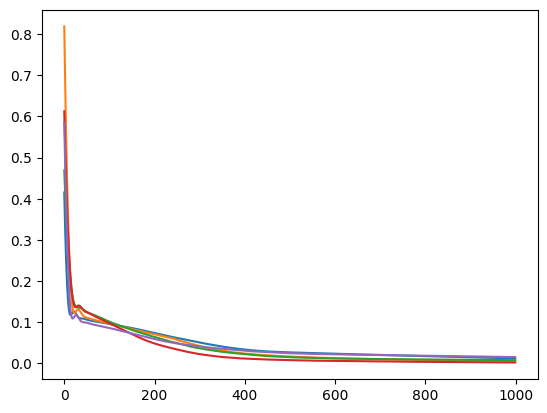

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# Define your regression model using Keras
def create_regression_model(input_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(input_dim,)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1)  # Output layer for regression, no activation function
    ])
    model.compile(optimizer='adam', loss='mse')  # Using Mean Squared Error for loss
    return model

# Data

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize list to store MSE scores
mse_scores = []

# Perform 5-fold cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index, 1], y[test_index, 1]

    # Create and train the model
    model = create_regression_model(X_train.shape[1])
    history = model.fit(X_train, y_train, epochs=1000, verbose=0)  # Adjust epochs as needed

    # Evaluate the model
    y_pred = model.predict(X_test)

    # Calculate Mean Squared Error
    mse = mean_squared_error(y_test, y_pred)

    # Append MSE to list
    mse_scores.append(mse)
    plt.plot(history.history['loss'])

# Calculate mean and standard deviation of MSE
mse_mean = np.mean(mse_scores)
mse_std = np.std(mse_scores)

# Print results
print("Mean Squared Error (MSE): {:.4f} +/- {:.4f}".format(mse_mean, mse_std))


In [ ]:
model.fit

array([0.92857143, 0.85714286, 0.71428571, 0.28571429, 0.14285714,
       0.        ])

In [ ]:
model = create_regression_model(X_train.shape[1])
history = model.fit(X, y[:,1], epochs=1000, verbose=0)  # Adjust epochs as needed

In [ ]:
for var in ['aroma', 'dulce', 'amargor', 'acidez', 'astringencia', 'velocidad fusion']:
    df_vars, df_ma, anotadores = create_dfs(df_comb.copy(), df_most_common.iloc[0,:-1].values, [var], 5, 'all')
    print(var)
    print(anotadores)
    print(len(df_vars))

aroma
['155', '160', '179', '135', '154']
591
dulce
['155', '160', '135', '179', '154']
602
amargor
['155', '160', '135', '179', '154']
377
acidez
['155', '160', '135', '179', '154']
380
astringencia
['155', '160', '135', '179', '154']
318
velocidad fusion
['155', '160', '135', '179', '154']
602


In [ ]:
df_vars, df_ma, anotadores = create_dfs(df_comb.copy(), df_most_common.iloc[0,:-1].values, ['aroma', 'dulce', 'amargor', 'acidez', 'astringencia', 'velocidad fusion'], 5, 'all')
df_vars.shape

(307, 5)

In [ ]:
df_ma

acidez                     amargor                     aroma  \
codigo evaluador    135  154  155  160  179     135  154  155  160  179   135   
codigo sampler                                                                  
D01221695           2.0  2.0  3.0  NaN  NaN     5.0  4.0  4.0  NaN  NaN   6.0   
D01221946           0.0  0.0  1.0  NaN  NaN     0.0  0.0  1.0  NaN  NaN   6.5   
D01221978           1.0  0.0  1.0  NaN  1.0     4.0  3.0  3.0  NaN  4.0   6.5   
D01222198           2.0  0.0  1.0  NaN  2.5     5.0  6.0  5.0  NaN  2.0   6.0   
D01222283           1.0  0.0  1.0  NaN  2.0     4.0  3.0  2.0  NaN  3.0   6.0   
...                 ...  ...  ...  ...  ...     ...  ...  ...  ...  ...   ...   
F12230552           NaN  NaN  3.0  NaN  NaN     NaN  NaN  5.0  NaN  NaN   NaN   
F12232202           NaN  NaN  1.0  1.0  2.0     NaN  NaN  6.0  5.0  5.0   NaN   
G01232116           2.0  NaN  1.0  NaN  3.0     7.0  NaN  8.0  NaN  5.0   6.0   
G01232117           0.0  NaN  1.0  0.0  2.0     5.0  NaN  7.0  5.0  4.0   5.0   
Z12231612           NaN  NaN  NaN  0.0  2.0     NaN  NaN  NaN  5.0  4.0   NaN   

                                     astringencia                     dulce  \
codigo evaluador  154  155  160  179          135  154  155  160  179   135   
codigo sampler                                                                
D01221695         6.0  5.0  NaN  NaN          2.0  2.0  3.0  NaN  NaN   6.5   
D01221946         6.0  5.0  NaN  NaN          0.0  0.0  1.0  NaN  NaN   6.5   
D01221978         6.0  5.0  NaN  4.0          0.0  0.0  1.0  NaN  2.0   6.5   
D01222198         6.0  5.0  NaN  5.0          0.0  2.0  3.0  NaN  2.0   6.5   
D01222283         6.0  5.0  NaN  3.0          3.0  0.0  5.0  NaN  4.0   5.5   
...               ...  ...  ...  ...          ...  ...  ...  ...  ...   ...   
F12230552         NaN  6.0  NaN  NaN          NaN  NaN  2.0  NaN  NaN   NaN   
F12232202         NaN  5.0  3.0  5.0          NaN  NaN  3.0  3.0  4.0   NaN   
G01232116         NaN  6.0  NaN  6.0          0.0  NaN  4.0  NaN  4.5   5.0   
G01232117         NaN  5.0  2.0  3.0          2.0  NaN  3.0  4.0  3.0   5.0   
Z12231612         NaN  NaN  3.0  5.0          NaN  NaN  NaN  4.0  5.0   NaN   

                                     velocidad fusion                      
codigo evaluador  154  155  160  179              135  154  155  160  179  
codigo sampler                                                             
D01221695         6.0  6.0  NaN  NaN             6.50  5.0  6.0  NaN  NaN  
D01221946         6.0  6.0  NaN  NaN             6.25  5.0  5.0  NaN  NaN  
D01221978         5.0  6.0  NaN  6.0             6.00  5.0  6.0  NaN  5.0  
D01222198         3.0  5.0  NaN  2.0             6.00  5.0  6.0  NaN  4.0  
D01222283         5.0  6.0  NaN  1.0             5.50  5.0  5.0  NaN  4.0  
...               ...  ...  ...  ...              ...  ...  ...  ...  ...  
F12230552         NaN  5.0  NaN  NaN              NaN  NaN  6.0  NaN  NaN  
F12232202         NaN  4.0  4.0  1.5              NaN  NaN  6.0  6.0  4.0  
G01232116         NaN  3.0  NaN  2.5             5.50  NaN  6.0  NaN  6.0  
G01232117         NaN  4.0  5.0  2.0             6.50  NaN  6.0  7.0  6.0  
Z12231612         NaN  NaN  4.0  3.0              NaN  NaN  NaN  4.0  2.0  

[307 rows x 30 columns]

In [ ]:
df_ma.count()

                  codigo evaluador
acidez            135                 161
                  154                 111
                  155                 179
                  160                 165
                  179                 142
amargor           135                 162
                  154                 111
                  155                 179
                  160                 165
                  179                 142
aroma             135                 162
                  154                 113
                  155                 180
                  160                 165
                  179                 144
astringencia      135                 162
                  154                 110
                  155                 178
                  160                 163
                  179                 141
dulce             135                 163
                  154                 112
                  155                 180

In [ ]:
for ann in ('135', '154', '155', '160', '179'):
    print(ann, end=': ')
    print(len(df_ma.loc[:,(slice(None), ann)].dropna()))

135: 160
154: 109
155: 178
160: 161
179: 141


In [ ]:
df_ma.columns.names

FrozenList([None, 'codigo evaluador'])

# By family: Dark Chocolate Rutinarios

In [21]:
df_comb['familia producto'].value_counts()

familia producto
Dark Chocolate Rutinarios            3560
Licor de cacao                       2135
Milk y White chocolate Rutinarios    1832
Consumo Masivo                       1482
Coberturas Sucedáneas                 856
                                     ... 
Trufas                                  3
Esencica                                2
Nuez de Brasil                          1
Nuez de Brazil                          1
Licor de planta con esencia             1
Name: count, Length: 74, dtype: int64

In [41]:
df_comb.iloc[0,:]['familia producto']

'Dark Chocolate Rutinarios'

In [47]:
mask = (df_comb['familia producto'] == 'Dark Chocolate Rutinarios') | (df_comb['familia producto'] == 'Dark Chocolate Rutinario')
df_chocolate = df_comb[mask]
df_chocolate

,codigo sampler,hora inicio,hora finalizacion,muestra,codigo evaluador,familia producto,producto,acidez,adherencia,almendra,amargor,apariencia,aroma,astringencia,avena/cereal,brillo,cacao,color_x,cremosidad,crocancia,cuerpo,dulce,dureza,esencia,floral,frutal,granulosidad,impresion global,lacteo,marañon,mohoso,nuez,sabor,sabor cacao,sabor cafe,sabor cocoa,sal,tamaño,textura,velocidad fusion,verde,aspecto,avena,caramelo,olor,mani,sabor atipico/extraño,terroso,sabor residual,solidos en suspension,piña,sedimento_x,cafe,intensidad,forma,maderoso,sabor coco,albaricoque,cardamomo,mango,panela/malta,sabor lacteo,manchoso,sabor caramelo,coco,sabor chocolate,cereal,viscosidad,fluidez,macadamia,proteina,quinua,rancidez,fermentado,comentarios,observaciones,¿que otros atributos considera importante evaluar en el producto?,cual fue tu impresion global sobre esta muestra?,por favor ayudanos caracterizar esta muestra para una mejor interpretacion tus resultados,¿que otras caracteristicas consideran importantes evaluar en el producto?,estatus,CodMuestra,FechaHoraMuestra,Matriz,SubMatriz,actividad de agua,almendra elisa,analisis externos,analisis fisico corto,analisis fisico iso,azucares reductores,cadmio - faas llama,cadmio - faas llama,cadmio - faas llama [cascarilla],cadmio - faas llama [nibs],cadmio a - faas llama,cadmio b - faas llama,cadmio- gfaas horno de grafito,cascarilla en nibs,cenizas totales,...,granulometría - difracción de rayos laser [pulverizado 12%],granulometría - difracción de rayos laser [pulverizado 16%],granulometría - difracción de rayos laser [pulverizado lecitinado],granulometría - micrometro,granulometría azucar malla astm 20,granulometría azucar malla astm 40,granulometría cho mesa malla astm 25,granulometría malla astm 20,granulometría malla astm 200,granulometría panela malla astm 20,granulometría panela malla astm 40,granulometría panela malla astm 60,"granulometría retenido malla 25, 40, 200 astm","granulometría retenido malla 70, 80, 100 astm",grasa - cálculo,grasa - nir,grasa - nir [licor],grasa - nmr,grasa - nmr [licor],grasa - nmr [duplicado],grasa - soxhlet,humedad - desecación,humedad - determinador de humedad en granos,humedad - determinador halogeno,humedad - determinador halogeno [licor],impurezas,inclusiones totales en malla astm 80,indice de grano,instantaneidad,leche total fl - 3m,leche total fl - r-biopharm,leche total r-biopharm,leche total romer,limite de fluidez,limite de fluidez anton paar,limite de fluidez brookfield,limite de fluidez [duplicado] anton paar,limite de fluidez [preliminar],limite de fluidez nca/cma,listeria monocytogenes - instalaciones,listeria monocytogenes - iso instalaciones,listeria monocytogenes - mds instalaciones,listeria monocytogenes/25g,listeria monocytogenes/25g - iso,listeria monocytogenes/25g mds,listeria monocytogenes/ml,mani elisa,material extraño,nibs en cascarilla,ph,plomo - gfaas horno de grafito,recuento de bacillus cereus,recuento de bacterias lipoliticas,recuento de coliformes totales - manipulador,recuento de coliformes totales - petrifilm,recuento de coliformes totales - siembra en placa,recuento de e. coli - petrifilm,recuento de e. coli - siembra en placa,recuento de enterobacterias - siembra en placa,recuento de mesofilos aerobios - impactación en placa,recuento de mesofilos aerobios - petrifilm,recuento de mesofilos aerobios - siembra en placa,recuento de mohos y levaduras - impactación en placa,recuento de mohos y levaduras - nacional,recuento de mohos y levaduras - petrifilm,recuento de mohos y levaduras - petrifilm (ma044,recuento de mohos y levaduras - siembra en placa,recuento de staphylococcus aureus,residuo,salmonella - instalaciones,salmonella - iso instalaciones,salmonella - mds instalaciones,salmonella/25g,salmonella/25g iso,salmonella/25g mds,salmonella/25g mds b,salmonella/375g iso,salmonella/375g mds,sedimento_y,sedimento - panela,soya,soya - 3m,soya elisa,soya elisa romer,staphylococcus aureus - ausencia / presencia,viscosidad aparente,vis

In [49]:
df_chocolate['muestra'].nunique()

749

In [38]:
df_comb.groupby('familia producto')['muestra'].nunique().sort_values()

familia producto
Crema de maní                          1
Dark chocolate rutinario               1
Trufas                                 1
Campano                                1
Manteca de  cacao                      1
                                    ... 
Coberturas Sucedáneas                213
Consumo Masivo                       306
Licor de cacao                       361
Milk y White chocolate Rutinarios    403
Dark Chocolate Rutinarios            728
Name: muestra, Length: 74, dtype: int64

In [62]:
df_chocolate = df_chocolate.dropna(axis=1, how='all')
df_chocolate.shape

(3735, 114)

In [64]:
df_chocolate.count().describe()

count     114.000000
mean      996.736842
std      1486.080216
min         1.000000
25%        10.000000
50%       124.000000
75%      1573.500000
max      3735.000000
dtype: float64

<Axes: >

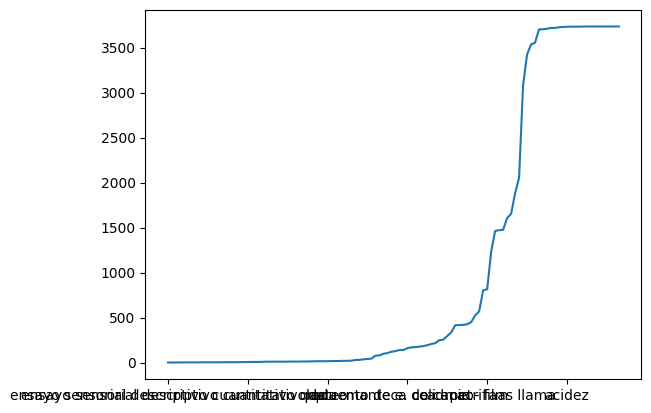

In [68]:
df_chocolate.count().sort_values().plot()

In [84]:
df_chocolate['codigo evaluador'].value_counts()

codigo evaluador
155    509
160    476
135    418
179    354
154    328
132    281
139    147
188    107
186     99
169     96
101     94
117     93
102     81
176     77
165     72
161     61
164     59
137     44
172     42
104     42
141     38
170     38
136     32
134     27
114     26
143     21
127     17
151     12
178     12
177     10
17       3
16       3
187      2
15t      1
314      1
15       1
207      1
184      1
264      1
541      1
873      1
148      1
967      1
121      1
195      1
123      1
598      1
Name: count, dtype: int64

In [82]:
annotators_choco = df_chocolate['codigo evaluador'].value_counts()[:10].index.to_list()
annotators_choco

['155', '160', '135', '179', '154', '132', '139', '188', '186', '169']

In [73]:
df_fq

,CodMuestra,FechaHoraMuestra,Matriz,SubMatriz,actividad de agua,almendra elisa,analisis externos,analisis fisico corto,analisis fisico iso,azucares reductores,cadmio - faas llama,cadmio - faas llama,cadmio - faas llama [cascarilla],cadmio - faas llama [nibs],cadmio a - faas llama,cadmio b - faas llama,cadmio- gfaas horno de grafito,cascarilla en nibs,cenizas totales,chocolate con plátano y caramelo,coco elisa,color,concentración desinfectante [%],concentración desinfectante [ppm],contenido de inclusiones barras con inclusiones,contenido de inclusiones - cálculo drops con inclusiones,contenido de inclusiones - cálculo nibs y platanitos,conteo de grano,densidad,densidad barras,densidad aparente,densidad aparente instantaneos,e. coli ausencia / presencia,ensayo descriptivo detallado prodijelly,ensayo sensorial descriptivo heb dark chocolate 54% tamarind,ensayo sensorial descriptivo cualitativo básico,ensayo sensorial descriptivo cuantitativo qda,ensayo sensorial descriptivo cuantitativo qda 22-24%,ensayo sensorial descriptivo cuantitativo qda almendra recubierta de chocolate,ensayo sensorial descriptivo cuantitativo qda almond butter cups,ensayo sensorial descriptivo cuantitativo qda brownie,ensayo sensorial descriptivo cuantitativo qda café recubierto de chocolate,ensayo sensorial descriptivo cuantitativo qda chocolate con arándanos y frutos rojos,ensayo sensorial descriptivo cuantitativo qda chocolate con guayaba y mango,ensayo sensorial descriptivo cuantitativo qda chocolate con inclusiones,ensayo sensorial descriptivo cuantitativo qda chocolate de avena,ensayo sensorial descriptivo cuantitativo qda chocolate de mesa con azucar,ensayo sensorial descriptivo cuantitativo qda chocolate de mesa con azucar instantaneo,ensayo sensorial descriptivo cuantitativo qda chocolate de mesa con azucar y esencia,ensayo sensorial descriptivo cuantitativo qda chocolate de mesa con edulcorante y esencia,ensayo sensorial descriptivo cuantitativo qda chocolate de mesa polvo con edulcorante,ensayo sensorial descriptivo cuantitativo qda chocolate de mesa sin azucar,ensayo sensorial descriptivo cuantitativo qda chocolate de mesa sin azucar y esencia,ensayo sensorial descriptivo cuantitativo qda chocolate real blanco,ensayo sensorial descriptivo cuantitativo qda chocolate real con leche,ensayo sensorial descriptivo cuantitativo qda chocolate sucedaneo blanco,ensayo sensorial descriptivo cuantitativo qda chocolate sucedaneo oscuro,ensayo sensorial descriptivo cuantitativo qda chocolate sucedáneo con leche,ensayo sensorial descriptivo cuantitativo qda comparativo,ensayo sensorial descriptivo cuantitativo qda cualitativo,ensayo sensorial descriptivo cuantitativo qda dark chocolate,ensayo sensorial descriptivo cuantitativo qda dark chocolate 70% with coconut sugar,ensayo sensorial descriptivo cuantitativo qda dark chocolate de avena,ensayo sensorial descriptivo cuantitativo qda esencias y sabores,ensayo sensorial descriptivo cuantitativo qda heb dark chocolate 54% tamarind,ensayo sensorial descriptivo cuantitativo qda jalea de guayaba recubierta de chocolate,ensayo sensorial descriptivo cuantitativo qda jugos de cacao,ensayo sensorial descriptivo cuantitativo qda jugos de cacao/mucilago,ensayo sensorial descriptivo cuantitativo qda levantamiento de perfil,ensayo sensorial descriptivo cuantitativo qda licor/pasta/masa de cacao,ensayo sensorial descriptivo cuantitativo qda macadamia recubierta de chocolate,ensayo sensorial descriptivo cuantitativo qda manteca de cacao,ensayo sensorial descriptivo cuantitativo qda mezcla de cocoa y azúcar,"ensayo sensorial descriptivo cuantitativo qda mezcla en polvo de cocoa, azucar, vitaminas y minerales",ensayo sensorial descriptivo cuantitativo qda nibs de cacao recubiertos de chocolate,ensayo sensorial descriptivo cuantitativo qda nibs de cacao tostados,ensayo sensorial descriptivo cuantitativo qda panela,ensayo sensorial descriptivo cuantitativo qda pastillas de cocoa con azucar,ensayo sensorial descriptivo cuantitativ

In [74]:
df_fq.CodMuestra.nunique()

104993

In [76]:
df_sens

,codigo sampler,hora inicio,hora finalizacion,muestra,codigo evaluador,familia producto,producto,acidez,adherencia,almendra,amargor,apariencia,aroma,astringencia,avena/cereal,brillo,cacao,color,cremosidad,crocancia,cuerpo,dulce,dureza,esencia,floral,frutal,granulosidad,impresion global,lacteo,marañon,mohoso,nuez,sabor,sabor cacao,sabor cafe,sabor cocoa,sal,tamaño,textura,velocidad fusion,verde,aspecto,avena,caramelo,olor,mani,sabor atipico/extraño,terroso,sabor residual,solidos en suspension,piña,sedimento,cafe,intensidad,forma,maderoso,sabor coco,albaricoque,cardamomo,mango,panela/malta,sabor lacteo,manchoso,sabor caramelo,coco,sabor chocolate,cereal,viscosidad,fluidez,macadamia,proteina,quinua,rancidez,fermentado,comentarios,observaciones,¿que otros atributos considera importante evaluar en el producto?,cual fue tu impresion global sobre esta muestra?,por favor ayudanos caracterizar esta muestra para una mejor interpretacion tus resultados,¿que otras caracteristicas consideran importantes evaluar en el producto?,estatus
0,D03221578,2022-04-22 11:06:18,2022-04-22 11:10:32,967.0,160,Dark Chocolate Rutinarios,marcha rich,1.0,NaN,0.0,4.0,NaN,4.0,2.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,3.0,5.0,0.0,NaN,0.0,NaN,8.0,NaN,NaN,NaN,0.0,NaN,6.0,NaN,NaN,0.0,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,muestra con aroma chocolatoso sabor amargo dul...,NaN,NaN,NaN,NaN,NaN
1,D03221578,2022-04-22 11:07:58,2022-04-22 11:11:00,967.0,154,Dark Chocolate Rutinarios,match rich,0.0,NaN,0.0,3.0,NaN,6.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,5.0,5.0,0.0,NaN,0.0,NaN,8.0,NaN,NaN,NaN,0.0,NaN,5.0,NaN,NaN,0.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,aroma y sabor chocolatos funde facil leve crem...,NaN,NaN,NaN,NaN,NaN
2,D04221765,2022-04-22 11:10:35,2022-04-22 11:12:07,758.0,160,Dark Chocolate Rutinarios,dark chocolate 70 % organic petitorio,0.0,NaN,0.0,5.0,NaN,4.0,3.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.0,5.0,0.0,NaN,0.0,NaN,8.0,NaN,NaN,NaN,0.0,NaN,6.0,NaN,NaN,0.0,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,muestra con aroma y sabor tostado sabor amargo...,NaN,NaN,NaN,NaN,NaN
3,D04221765,2022-04-22 11:11:01,2022-04-22 11:12:13,758.0,154,Dark Chocolate Rutinarios,dark chocolate 70% organic petit,0.0,NaN,0.0,8.0,NaN,7.0,5.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,5.0,0.0,NaN,0.0,NaN,7.0,NaN,NaN,NaN,0.0,NaN,7.0,NaN,NaN,0.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,aroma y sabor tostado muy alto cacao alto fund...,NaN,NaN,NaN,NaN,NaN
4,D04221877,2022-04-22 11:12:14,2022-04-22 11:13:16,423.0,154,Dark Chocolate Rutinarios,dark 58%,0.0,NaN,0.0,4.0,NaN,6.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,5.0,5.0,0.0,NaN,0.0,NaN,8.0,NaN,NaN,NaN,0.0,NaN,5.0,NaN,NaN,0.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,aroma y sabor a cacao leve astringencia funde ...,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25889,Z09230090,2023-09-08 15:14:48,2023-09-08 15:17:05,400,141,Dark Chocolate Rutinarios,Fark mango,0.0,NaN,NaN,6.0,NaN,6.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,5.0,NaN,NaN,8.0,NaN,5.0,NaN,NaN,NaN,0.0,NaN,6.0,0.0,NaN,0.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,Aroma y 